# Data Visualization & Feature Engineering & Forecasting

## Required Libraries & Packages

In [141]:
!pip install pandas matplotlib seaborn statsmodels numpy scipy pmdarima

## Code Functions Overview

This script contains multiple functions to visualizae and analyze the relationship between climate variables (temperature, humidity, wind speed, etc.) and energy demand. It generates various plots to visualize correlations, trends, and clustering effects.

In [5]:
#************************Start Code: Group#2********************************
#******Imports**************
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error,accuracy_score
import xgboost as xgb
#****************************************************************************
## Data Handling
# ***********load data***********   
def load_data(file_path):
    df = pd.read_csv(file_path, encoding='latin1')  # Use 'ISO-8859-1' if needed
    df['date'] = pd.to_datetime(df['datetime'], format="%d/%m/%Y %H:%M", errors='coerce')  
    df.set_index('date', inplace=True)  
    return df
#****************************************************************************
# ***********explore data***********   
def explore_data(data):
    print("Columns exist with sample rows data:")
    print(data.head())
    print("******************************************************************************************")
    print("Data Structural Info")
    print(data.info())
    print("******************************************************************************************")
    print("Data Statistics Info")
    print(data.describe())
    print("******************************************************************************************")
    print("Check All nulls values per column")
    print(data.isnull().sum())
#****************************************************************************
## Time Series Visualizations
# ***********plot time series***********   
def plot_time_series(df):
    plt.figure(figsize=(12, 6))
    plt.plot(df.index, df['hourly_demand'], label='Energy Demand')
    plt.title('Energy Demand Over Time')
    plt.xlabel('Date')
    plt.ylabel('Energy Demand')
    plt.legend()
    plt.grid(True)
    plt.show()
#****************************************************************************
# ***********plot price over time***********   
def plot_price_over_time(df):
    plt.figure(figsize=(12, 6))
    plt.plot(df.index, df['hourly_average_price'], label='Hourly Average Price', color='orange')
    plt.title('Energy Price Over Time')
    plt.xlabel('Date')
    plt.ylabel('Hourly Average Price (CAD)')
    plt.legend()
    plt.grid(True)
    plt.show()
#****************************************************************************
# ***********plot decomposition***********   
def plot_decomposition(df):
    result = seasonal_decompose(df['hourly_demand'], model='multiplicative', period=24)  # Daily cycle (period=24)
    result.plot()
    plt.show()
#****************************************************************************
def plot_temperature_trends(df_climate):
    plt.figure(figsize=(12, 6))
    plt.plot(df_climate.index, df_climate['Temp (°C)'], label='Temperature', color='red')
    plt.title('Temperature Trends Over Time')
    plt.xlabel('Date')
    plt.ylabel('Temperature (°C)')
    plt.legend()
    plt.grid(True)
    plt.show()
#****************************************************************************
def plot_humidity_trends(df_climate):
    plt.figure(figsize=(12, 6))
    plt.plot(df_climate.index, df_climate['Rel Hum (%)'], label='Relative Humidity', color='blue')
    plt.title('Humidity Trends Over Time')
    plt.xlabel('Date')
    plt.ylabel('Relative Humidity (%)')
    plt.legend()
    plt.grid(True)
    plt.show()
#****************************************************************************
# Plot wind chill trends over time
def plot_wind_chill_trends(df):
    plt.figure(figsize=(12, 6))
    plt.plot(df.index, df['Wind Chill'], label='Wind Chill', color='cyan')
    plt.title('Wind Chill Trends Over Time')
    plt.xlabel('Date')
    plt.ylabel('Wind Chill (°C)')
    plt.legend()
    plt.grid(True)
    plt.show()
#****************************************************************************
def plot_wind_speed_direction(df_climate):
    plt.figure(figsize=(12, 6))
    plt.scatter(df_climate['Wind Dir (10s deg)'], df_climate['Wind Spd (km/h)'], alpha=0.5, color='green')
    plt.title('Wind Speed vs. Wind Direction')
    plt.xlabel('Wind Direction (Degrees)')
    plt.ylabel('Wind Speed (km/h)')
    plt.grid(True)
    plt.show()
#****************************************************************************
# Plot wind speed vs energy demand
def plot_wind_speed_vs_energy(df):
    plt.figure(figsize=(12, 6))
    plt.scatter(df['Wind Spd (km/h)'], df['hourly_demand'], alpha=0.5, color='green')
    plt.title('Energy Demand vs Wind Speed')
    plt.xlabel('Wind Speed (km/h)')
    plt.ylabel('Energy Demand')
    plt.grid(True)
    plt.show()
#****************************************************************************
def plot_pressure_variations(df_climate):
    plt.figure(figsize=(12, 6))
    plt.plot(df_climate.index, df_climate['Stn Press (kPa)'], label='Station Pressure', color='purple')
    plt.title('Pressure Variations Over Time')
    plt.xlabel('Date')
    plt.ylabel('Pressure (kPa)')
    plt.legend()
    plt.grid(True)
    plt.show()
#****************************************************************************
## Correlation and Distribution Visualizations
#**********heatmap corr climate energy population**********************
def plot_correlation_matrix(df):
    numeric_df = df.select_dtypes(include=[np.number])  # Select only numeric columns
    plt.figure(figsize=(10, 6))
    sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
    plt.title('Correlation Matrix of Features')
    plt.show()
#****************************************************************************
#**********cross corr climate energy**********************
def plot_cross_correlation(merged_df, lag_range=48):
    cross_corr = [merged_df['hourly_demand'].corr(merged_df['Temp (°C)'].shift(lag)) for lag in range(-lag_range, lag_range)]
    lags = list(range(-lag_range, lag_range))
    
    plt.figure(figsize=(12, 6))
    plt.plot(lags, cross_corr, marker='o')
    plt.axvline(x=0, color='black', linestyle='--')
    plt.title('Cross-Correlation between Energy Demand and Temperature')
    plt.xlabel('Lag (hours)')
    plt.ylabel('Correlation')
    plt.grid(True)
    plt.show()
#****************************************************************************
# ***********plot rolling stats***********   
def plot_rolling_statistics(df):
    rolling_mean = df['hourly_demand'].rolling(window=30).mean()  # 30-hour rolling mean
    rolling_std = df['hourly_demand'].rolling(window=30).std()  # 30-hour rolling std deviation
    
    plt.figure(figsize=(12, 6))
    plt.plot(df.index, df['hourly_demand'], label='Original Energy Demand')
    plt.plot(df.index, rolling_mean, label='30-Hour Rolling Mean', color='red')
    plt.plot(df.index, rolling_std, label='30-Hour Rolling Std Dev', color='green')
    plt.title('Rolling Mean and Std Dev of Energy Demand')
    plt.xlabel('Date')
    plt.ylabel('Energy Demand')
    plt.legend()
    plt.show()
#****************************************************************************
# ***********plot auto correlation***********   
def plot_acf_pacf(df):
    plt.figure(figsize=(12, 6))
    plt.subplot(121)
    plot_acf(df['hourly_demand'], lags=50, ax=plt.gca())  # Adjust lags as needed
    plt.subplot(122)
    plot_pacf(df['hourly_demand'], lags=50, ax=plt.gca())  # Adjust lags as needed
    plt.show()
#****************************************************************************
# ***********plot demand vs price***********   
def plot_demand_vs_price(df):
    plt.figure(figsize=(12, 6))
    plt.scatter(df['hourly_average_price'], df['hourly_demand'], alpha=0.6)
    plt.title('Energy Demand vs Hourly Average Price')
    plt.xlabel('Hourly Average Price')
    plt.ylabel('Energy Demand')
    plt.show()
#****************************************************************************
# ***********plot seasonal patterns***********  
def plot_seasonal_patterns(df_climate):
    df_climate['month'] = df_climate.index.month
    monthly_avg_temp = df_climate.groupby('month')['Temp (°C)'].mean()
    
    plt.figure(figsize=(10, 6))
    monthly_avg_temp.plot(kind='bar', color='orange')
    plt.title('Average Monthly Temperature')
    plt.xlabel('Month')
    plt.ylabel('Temperature (°C)')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.show()
#****************************************************************************

def plot_seasonal_energy_demand(df):
    """
    Plots the average hourly energy demand by season.

    Parameters:
    - df (DataFrame): DataFrame with 'datetime' and 'hourly_demand' columns.

    Assumes 'datetime' is in "%d/%m/%Y %H:%M" format.
    """
    df = df.copy()
    
    # Ensure datetime index
    df['date'] = pd.to_datetime(df['datetime'], format="%d/%m/%Y %H:%M", errors='coerce')
    df = df.set_index('date')
    df = df[~df.index.duplicated(keep='first')]
    df = df.dropna(subset=['hourly_demand'])

    # Assign season based on month
    df['month'] = df.index.month
    df['season'] = df['month'].map({
        12: 'Winter', 1: 'Winter', 2: 'Winter',
        3: 'Spring', 4: 'Spring', 5: 'Spring',
        6: 'Summer', 7: 'Summer', 8: 'Summer',
        9: 'Fall', 10: 'Fall', 11: 'Fall'
    })

    # Average demand by season
    seasonal_demand = df.groupby('season')['hourly_demand'].mean().reindex(['Winter', 'Spring', 'Summer', 'Fall'])

    # Plot
    plt.figure(figsize=(8, 5))
    seasonal_demand.plot(kind='bar', color='skyblue')
    plt.title('Average Hourly Energy Demand by Season in Ontario')
    plt.ylabel('Average Hourly Demand (MW)')
    plt.xlabel('Season')
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()

# ***********plot extreme weather impact*********** 
def plot_extreme_weather_impact(merged_df):
    extreme_events = merged_df[(merged_df['Temp (°C)'] < -20) | (merged_df['Temp (°C)'] > 30)]
    
    plt.figure(figsize=(12, 6))
    plt.scatter(merged_df.index, merged_df['hourly_demand'], alpha=0.5, label='Normal Conditions')
    plt.scatter(extreme_events.index, extreme_events['hourly_demand'], color='red', label='Extreme Weather', alpha=0.7)
    plt.title('Impact of Extreme Weather on Energy Demand')
    plt.xlabel('Date')
    plt.ylabel('Energy Demand')
    plt.legend()
    plt.grid(True)
    plt.show()

#****************************************************************************
# ***********plot energy vs temperature over time***********  
def plot_energy_vs_temperature(merged_df):
    fig, ax1 = plt.subplots(figsize=(12, 6))
    
    # Plot Energy Demand on the first y-axis (left)
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Energy Demand', color='blue')
    ax1.plot(merged_df.index, merged_df['hourly_demand'], label='Energy Demand', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')
    
    # Create a second y-axis (right) for Temperature
    ax2 = ax1.twinx()
    ax2.set_ylabel('Temperature (°C)', color='red')
    ax2.plot(merged_df.index, merged_df['Temp (°C)'], label='Temperature (°C)', color='red')
    ax2.tick_params(axis='y', labelcolor='red')

    # Set the title and show the plot
    plt.title('Energy Demand vs Temperature Over Time')
    fig.tight_layout()  # To ensure proper layout
    plt.grid(True)
    plt.show()
#****************************************************************************
# ***********plot energy demand clusters***********  
def plot_energy_demand_clusters(merged_df):
    from sklearn.cluster import KMeans
    
    data = merged_df[['Temp (°C)', 'Rel Hum (%)', 'Wind Spd (km/h)', 'hourly_demand']].dropna()
    kmeans = KMeans(n_clusters=3, random_state=42).fit(data)
    data['Cluster'] = kmeans.labels_
    
    plt.figure(figsize=(12, 6))
    sns.scatterplot(x='Temp (°C)', y='hourly_demand', hue='Cluster', data=data, palette='viridis')
    plt.title('Energy Demand Clustering Based on Climate Variables')
    plt.xlabel('Temperature (°C)')
    plt.ylabel('Energy Demand')
    plt.show()
#****************************************************************************
#**************Population***********************
def plot_population_trend(merged_df):
    """ Plot population growth over time. """
    plt.figure(figsize=(10, 5))
    plt.plot(merged_df.index, merged_df['population'], marker='o', linestyle='-')
    plt.xlabel('Year')
    plt.ylabel('Population')
    plt.title('Ontario Population Over Time')
    plt.grid(True)
    plt.show()
#****************************************************************************
def plot_energy_vs_population(merged_df):
    """ Scatter plot of population vs. energy demand. """
    plt.figure(figsize=(8, 5))
    sns.scatterplot(x=merged_df['population'], y=merged_df['hourly_demand'])
    plt.xlabel('Population')
    plt.ylabel('Energy Demand')
    plt.title('Population vs. Energy Demand')
    plt.grid(True)
    plt.show()
#****************************************************************************
# ***********plot histogram***********  
def plot_histograms(merged_df, columns):
    """Plot histograms for selected numerical columns."""
    plt.figure(figsize=(12, 5))
    for i, col in enumerate(columns):
        plt.subplot(1, len(columns), i + 1)
        sns.histplot(merged_df[col], bins=20, kde=True, color='blue')
        plt.xlabel(col)
        plt.title(f'Distribution of {col}')
    plt.tight_layout()
    plt.show()
#*************Feature Engineering and Selection*********************
def compute_mutual_information(df, target_column):
    df = df.select_dtypes(include=[np.number])  # Ensure only numeric columns
    df = df.dropna()  # Drop rows with NaN values
    
    if target_column not in df.columns:
        raise ValueError(f"Target column '{target_column}' not found in dataframe.")
    
    X = df.drop(columns=[target_column], errors='ignore')  # Drop target variable
    y = df[target_column]
    
    mi = mutual_info_regression(X, y, random_state=42)
    mi_scores = pd.Series(mi, index=X.columns).sort_values(ascending=False)
    
    plt.figure(figsize=(10, 5))
    mi_scores.plot(kind='bar', color='teal')
    plt.title(f'Mutual Information Scores for Predicting {target_column}')
    plt.xlabel('Features')
    plt.ylabel('Mutual Information Score')
    plt.show()
    
    return mi_scores
#****************************************************************************
    ## Forecasting Visualizations

# ARIMA forecast
def plot_arima_forecast(df, order=(5,1,0)):
    model = ARIMA(df['hourly_demand'], order=order)
    model_fit = model.fit()
    forecast = model_fit.forecast(steps=30)
    
    plt.figure(figsize=(12, 6))
    plt.plot(df.index, df['hourly_demand'], label='Historical Energy Demand')
    plt.plot(pd.date_range(df.index[-1], periods=30, freq='H'), forecast, label='Forecast', color='red')
    plt.title('Energy Demand Forecast using ARIMA')
    plt.xlabel('Date')
    plt.ylabel('Energy Demand')
    plt.legend()
    plt.show()
#****************************************************************************
# SARIMA forecast
def forecast_sarima(df, periods=30):
    model = SARIMAX(df['hourly_demand'], order=(5,1,0), seasonal_order=(1,1,0,24))
    model_fit = model.fit(disp=False)
    forecast = model_fit.get_forecast(steps=periods)
    forecast_index = pd.date_range(df.index[-1], periods=periods+1, freq='H')[1:]
    
    forecast_mean = forecast.predicted_mean
    forecast_ci = forecast.conf_int()
    
    plt.figure(figsize=(12, 6))
    plt.plot(df.index, df['hourly_demand'], label='Historical Data', color='blue')
    plt.plot(forecast_index, forecast_mean, label='Forecasted Demand', color='red')
    plt.fill_between(forecast_index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='pink', alpha=0.3)
    plt.title('Energy Demand Forecast using SARIMA')
    plt.xlabel('Date')
    plt.ylabel('Energy Demand')
    plt.legend()
    plt.show()
    
    return forecast_mean, forecast_ci, forecast_index
#****************************************************************************
def plot_train_test(df):
    train = df.loc[df.index < '01-01-2020']
    test = df.loc[df.index >= '01-01-2020']
    
    fig, ax = plt.subplots(figsize=(20, 5))
    train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
    test.plot(ax=ax, label='Test Set')
    ax.axvline('01-01-2020', color='black', ls='--')
    ax.legend(['Training Set', 'Test Set'])
    plt.show()

#****************************************************************************
def split_timeseries(df):
    tss = TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24)
    df = df.sort_index()
    return df,tss
#****************************************************************************
def plot_train_folds(df,tss):
    fig, axs = plt.subplots(5, 1, figsize=(20, 15), sharex=True)

    fold = 0
    for train_idx, val_idx in tss.split(df):
        train = df.iloc[train_idx]
        test = df.iloc[val_idx]
        train['hourly_demand'].plot(ax=axs[fold],
                              label='Training Set',
                              title=f'Data Train/Test Split Fold {fold}')
        test['hourly_demand'].plot(ax=axs[fold],
                             label='Test Set')
        axs[fold].axvline(test.index.min(), color='black', ls='--')
        fold += 1
    plt.show()
#****************************************************************************
def add_lags(df):
    target_map = df['hourly_demand'].to_dict()
    df['lag1'] = (df.index - pd.Timedelta('364 days')).map(target_map)
    df['lag2'] = (df.index - pd.Timedelta('728 days')).map(target_map)
    df['lag3'] = (df.index - pd.Timedelta('1092 days')).map(target_map)
    return df
#****************************************************************************
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df
#****************************************************************************
def xgboost_train(df):
    tss = TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24)
    df = df.sort_index()
    
    
    fold = 0
    preds = []
    scores = []
    acc_scores=[]
    for train_idx, val_idx in tss.split(df):
        train = df.iloc[train_idx]
        test = df.iloc[val_idx]
    
        FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year', 'lag1', 'lag2', 'lag3', 'Temp (°C)', 'hourly_average_price', 'population','Wind Chill']
        TARGET = 'hourly_demand'
    
        X_train = train[FEATURES]
        y_train = train[TARGET]
    
        X_test = test[FEATURES]
        y_test = test[TARGET]
    
        reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                               n_estimators=1000,
                               early_stopping_rounds=50,
                               objective='reg:linear',
                               max_depth=3,
                               learning_rate=0.01)
        reg.fit(X_train, y_train,
                eval_set=[(X_train, y_train), (X_test, y_test)],
                verbose=100)
    
        y_pred = reg.predict(X_test)
        preds.append(y_pred)
        score = np.sqrt(mean_squared_error(y_test, y_pred))
        scores.append(score)
        print(f'Score across folds {np.mean(scores):0.4f}')
        print(f'Fold scores:{scores}')
        # Save model
        reg.save_model('ds_xgb_model.json')
        return reg,scores
#****************************************************************************
def predict_future_demand(df,reg):
    # Create future dataframe 2023-04-03 23:00:00	
    future = pd.date_range('2023-04-03','2025-04-03', freq='1h')
    future_df = pd.DataFrame(index=future)
    future_df['isFuture'] = True
    df['isFuture'] = False
    df_and_future = pd.concat([df, future_df])
    df_and_future = create_features(df_and_future)
    df_and_future = add_lags(df_and_future)
    FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year', 'lag1', 'lag2', 'lag3', 'Temp (°C)', 'hourly_average_price', 'population','Wind Chill']
    future_w_features = df_and_future.query('isFuture').copy()
    future_w_features['pred'] = reg.predict(future_w_features[FEATURES])
    future_w_features['pred'].plot(figsize=(20, 5),
                               color="Blue",
                               ms=1,
                               lw=1,
                               title='Future Predictions of Energy Demand')
    plt.show()
#****************************************************************************
def plot_actual_vs_predicted(df, reg):
    """
    Plots actual vs predicted energy demand for the test set using the trained XGBoost model.
    """
    # Create time series split object (same as used during training)
    tss = TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24)
    df = df.sort_index()

    FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year', 'lag1', 'lag2', 'lag3', 'Temp (°C)', 'hourly_average_price', 'population','Wind Chill']
    TARGET = 'hourly_demand'

    fig, axs = plt.subplots(5, 1, figsize=(20, 18), sharex=True)

    for fold, (train_idx, test_idx) in enumerate(tss.split(df)):
        train = df.iloc[train_idx]
        test = df.iloc[test_idx]

        X_test = test[FEATURES]
        y_test = test[TARGET]

        y_pred = reg.predict(X_test)

        axs[fold].plot(test.index, y_test, label='Actual', color='blue')
        axs[fold].plot(test.index, y_pred, label='Predicted', color='orange')
        axs[fold].set_title(f'Fold {fold}: Actual vs Predicted Energy Demand')
        axs[fold].legend()
        axs[fold].grid(True)

    plt.tight_layout()
    plt.show()
#****************************************************************************

#************************End Code: Group#2***********************************

## Function Documentation: `load_data(file_path)`

### Purpose
The `load_data` function is responsible for loading the dataset from a CSV file, parsing the date-time column, and setting it as the index to facilitate time-series analysis.

### How It Works
1. Reads the CSV file using `pd.read_csv(file_path, encoding='latin1')` to handle special characters.
2. Converts the `datetime` column into a proper datetime format using `pd.to_datetime` with the specified format `%d/%m/%Y %H:%M`.
3. Sets the `datetime` column as the index of the DataFrame for time-series operations.
4. Returns the cleaned DataFrame.

### What to Look For
- Ensure that the `datetime` column exists in the dataset before conversion.
- Check for `NaT` (Not a Time) values that may arise due to incorrect formatting.
- Verify that the index is correctly set and sorted for time-series operations.

### Insights
- Proper datetime formatting allows for easier time-series analysis.
- Setting `datetime` as an index helps in resampling, rolling statistics, and forecasting models.
- Handling encoding issues prevents errors when reading CSV files containing special characters.

---



In [9]:
file_path = 'final_merged_ontario_dataset.csv'
df = load_data(file_path)

## Function Documentation: Time Series Split & Visualization

This documentation covers three closely related functions used to prepare and visualize training and testing splits in time series forecasting: `split_timeseries`, `plot_train_test`, and `plot_train_folds`.

---

### Function: `split_timeseries(df)`

#### Purpose
Prepares a time series dataset for cross-validation by creating a `TimeSeriesSplit` object with fixed parameters.

#### How It Works
1. Initializes `TimeSeriesSplit` with:
   - `n_splits=5`: 5 consecutive training/testing folds.
   - `test_size=24*365*1`: Each test fold spans one year (8,760 hours).
   - `gap=24`: Introduces a 24-hour gap to avoid data leakage.
2. Sorts the dataframe chronologically.
3. Returns the sorted DataFrame and the `TimeSeriesSplit` object.

#### What to Look For
- Ensures **temporal integrity** of splits.
- Prevents **leakage** between train/test sets.

#### Insights
- Supports rolling-window evaluation.
- Foundation for robust forecasting workflows.

---

### Function: `plot_train_test(df)`

#### Purpose
Visualizes a static split of the dataset into training and testing sets based on a fixed date.

#### How It Works
1. Splits the data at `'01-01-2020'` into `train` and `test` sets.
2. Plots both sets on the same timeline.
3. Adds a vertical line to highlight the split point.

#### What to Look For
- Distribution and balance of data before and after the split.
- Change in demand patterns near the cutoff.

#### Insights
- Useful for initial exploratory data analysis.
- Provides visual confirmation of split boundaries.

---

### Function: `plot_train_folds(df, tss)`

#### Purpose
Visualizes all the training and validation splits created by `TimeSeriesSplit`.

#### How It Works
1. Iterates through each fold produced by `tss.split(df)`.
2. Plots the `hourly_demand` for training and testing sets in each fold.
3. Adds a vertical line to show the start of the test set.

#### What to Look For
- Visual consistency across folds.
- Seasonal or cyclical behavior within folds.

#### Insights
- Enables comparison of model performance across different time windows.
- Ensures fairness and balance across validation splits.

---



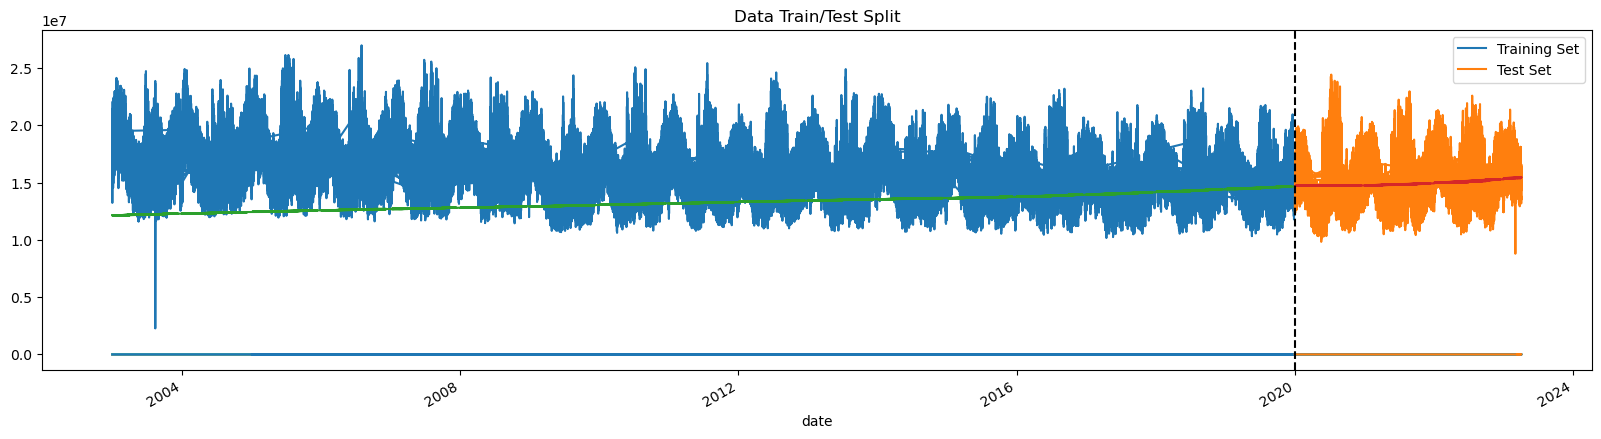

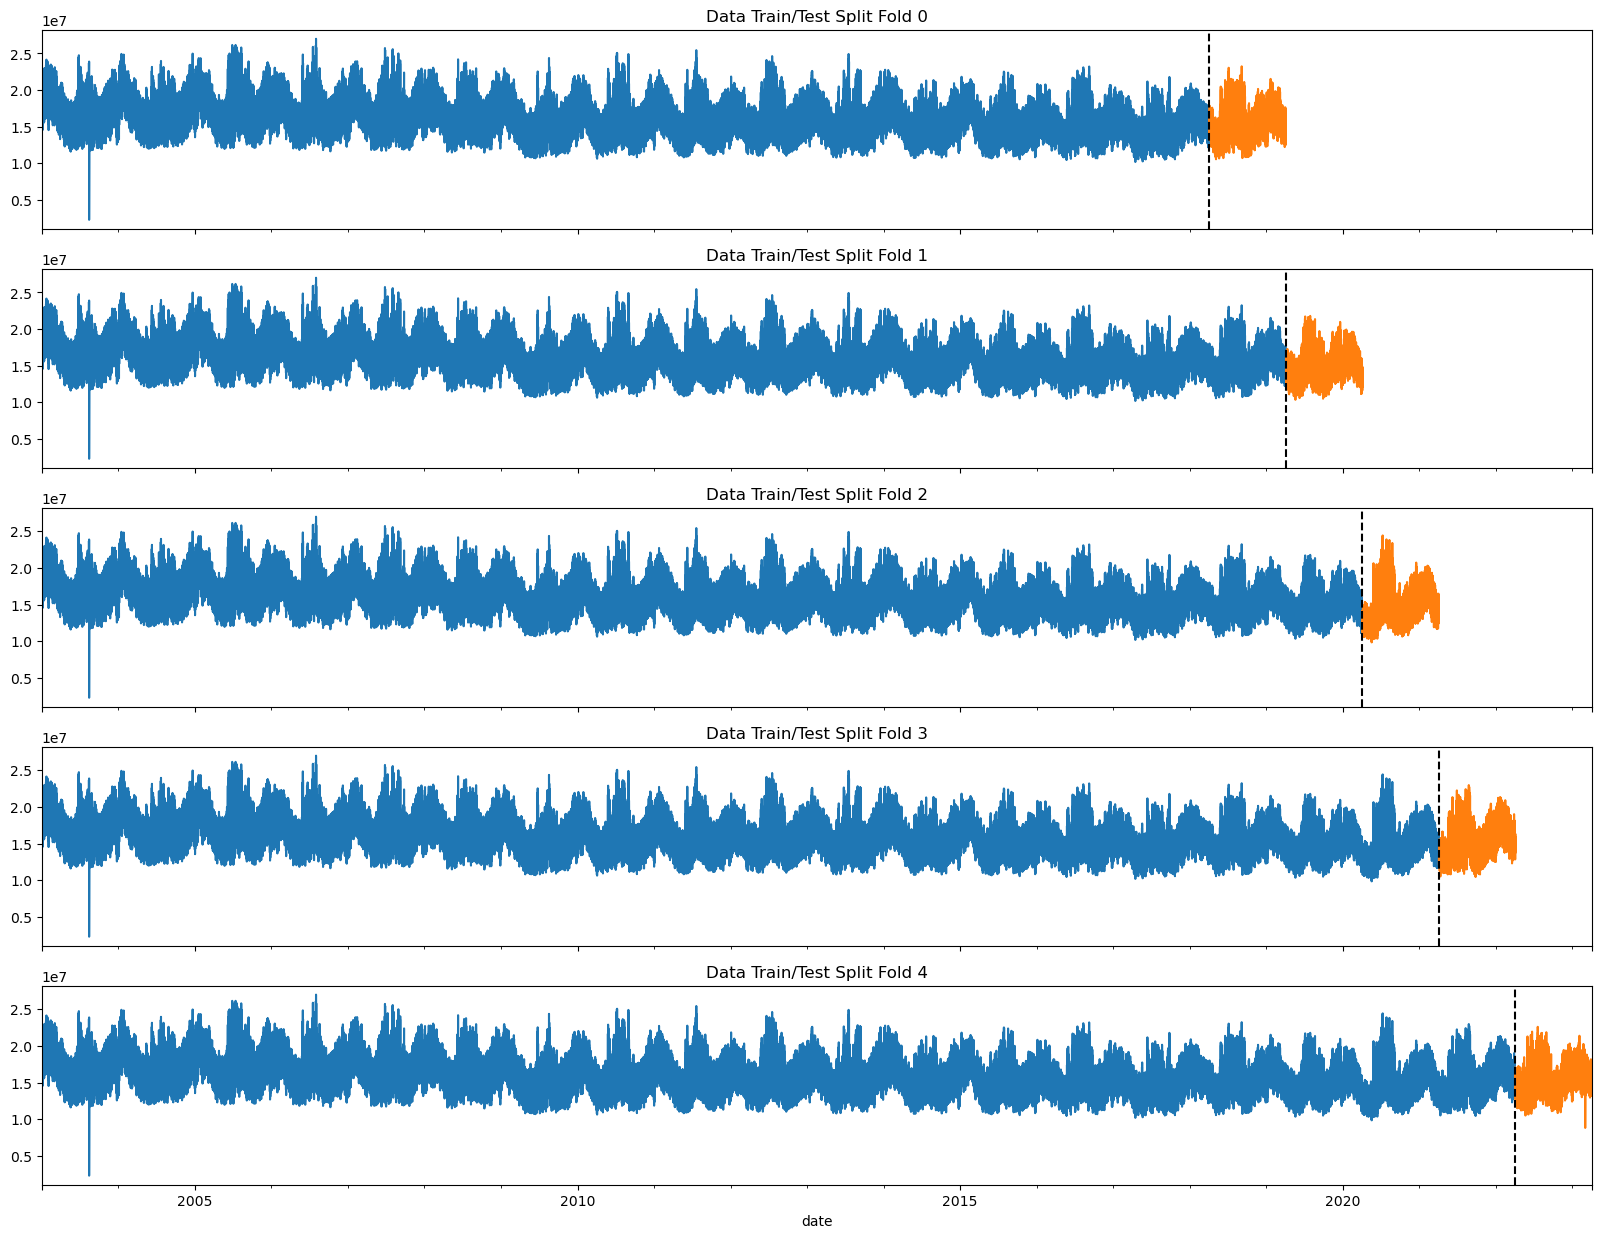

In [11]:
plot_train_test(df)
df,tss=split_timeseries(df)
plot_train_folds(df,tss)


## Function Documentation: Feature Engineering & XGBoost Training

This documentation covers the core functions used to engineer features and train an XGBoost regression model for energy demand forecasting.

---

### Function: `add_lags(df)`

#### Purpose
Adds lag features to the dataset based on the target variable `hourly_demand`, using values from the same hour in previous years.

#### How It Works
- Uses the time index to map `hourly_demand` values from:
  - 364 days ago (`lag1`)
  - 728 days ago (`lag2`)
  - 1092 days ago (`lag3`)
- Adds these lagged values as new columns in the dataframe.

#### What to Look For
- Ensure time index is in hourly datetime format.
- Expect missing values in early rows where no prior data exists.

#### Insights
- Captures yearly seasonality in demand.
- Essential for time-aware models like XGBoost to learn from past behavior.

---

### Function: `create_features(df)`

#### Purpose
Extracts rich datetime-based features from the datetime index to enhance model learning.

#### How It Works
- Derives new features such as:
  - `hour`, `dayofweek`, `quarter`, `month`, `year`, `dayofyear`, `dayofmonth`, `weekofyear`
- Returns a copy of the dataframe with these columns added.

#### What to Look For
- Feature distributions that reflect time-based cycles (daily, weekly, yearly).
- Use these features to help the model capture short and long-term seasonality.

#### Insights
- Adds interpretability and temporal patterns to the dataset.
- Useful across various forecasting models.

---

### Function: `xgboost_train(df)`

#### Purpose
Trains an XGBoost regressor using time series cross-validation and engineered features.

#### How It Works
1. Initializes `TimeSeriesSplit` for 5-fold validation with a 1-year test window.
2. Defines:
   - **Features**: includes lags, datetime features, weather and socio-economic variables.
   - **Target**: `hourly_demand`
3. Trains an `XGBRegressor` with:
   - 1000 estimators, learning rate 0.01, and early stopping.
4. Evaluates performance using RMSE on each fold and prints scores.
5. Saves the final model to `ds_xgb_model.json`.

#### What to Look For
- Gradual performance improvement across folds.
- Reasonable RMSE values (lower is better).

#### Insights
- XGBoost handles feature interactions and nonlinearities.
- Provides a powerful forecasting engine when combined with lag, time, and external features.

---

In [15]:
df = create_features(df)
df = add_lags(df)
reg,scores=xgboost_train(df)

[0]	validation_0-rmse:16496657.19558	validation_1-rmse:15790124.70173


C:\Users\waela\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [11:47:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:6160326.24825	validation_1-rmse:6235343.28554
[200]	validation_0-rmse:2502795.27442	validation_1-rmse:2794702.22968
[300]	validation_0-rmse:1366599.80821	validation_1-rmse:1613944.95105
[400]	validation_0-rmse:1091454.19978	validation_1-rmse:1265095.72142
[500]	validation_0-rmse:1023581.89942	validation_1-rmse:1155929.07311
[600]	validation_0-rmse:993906.90230	validation_1-rmse:1111414.53359
[700]	validation_0-rmse:974608.87715	validation_1-rmse:1086597.41935
[800]	validation_0-rmse:959696.47605	validation_1-rmse:1079013.59689
[900]	validation_0-rmse:947783.60269	validation_1-rmse:1069100.94553
[999]	validation_0-rmse:935852.43792	validation_1-rmse:1060174.72424
Score across folds 1060174.7248
Fold scores:[1060174.7248262395]


## Function Documentation: `plot_actual_vs_predicted(df, reg)`

### Purpose
Visualizes the actual vs predicted energy demand across all time series cross-validation folds using the trained XGBoost model.

### How It Works
1. **Initializes TimeSeriesSplit**:
   - Splits the data into 5 folds with 1-year test periods and a 1-day gap.
2. **Defines Features and Target**:
   - Uses engineered features like lags, datetime elements, and external variables (e.g., temperature, population).
3. **Iterates Through Folds**:
   - For each fold:
     - Trains on earlier data.
     - Tests the model on the next test fold.
     - Uses the trained `reg` model to predict demand.
     - Plots both actual and predicted values on a shared time axis.
4. **Creates a Subplot per Fold**:
   - Visualizes actual (`blue`) vs predicted (`orange`) values for each fold.

### What to Look For
- How closely the predicted line follows the actual demand.
- Consistency of prediction quality across folds.
- Presence of seasonal spikes, sudden changes, or underfitting/overfitting patterns.

### Insights
- Helps visually validate the XGBoost model’s effectiveness across time.
- A useful diagnostic tool to evaluate model generalization.
- Identifies specific time periods or patterns the model may struggle with.

---



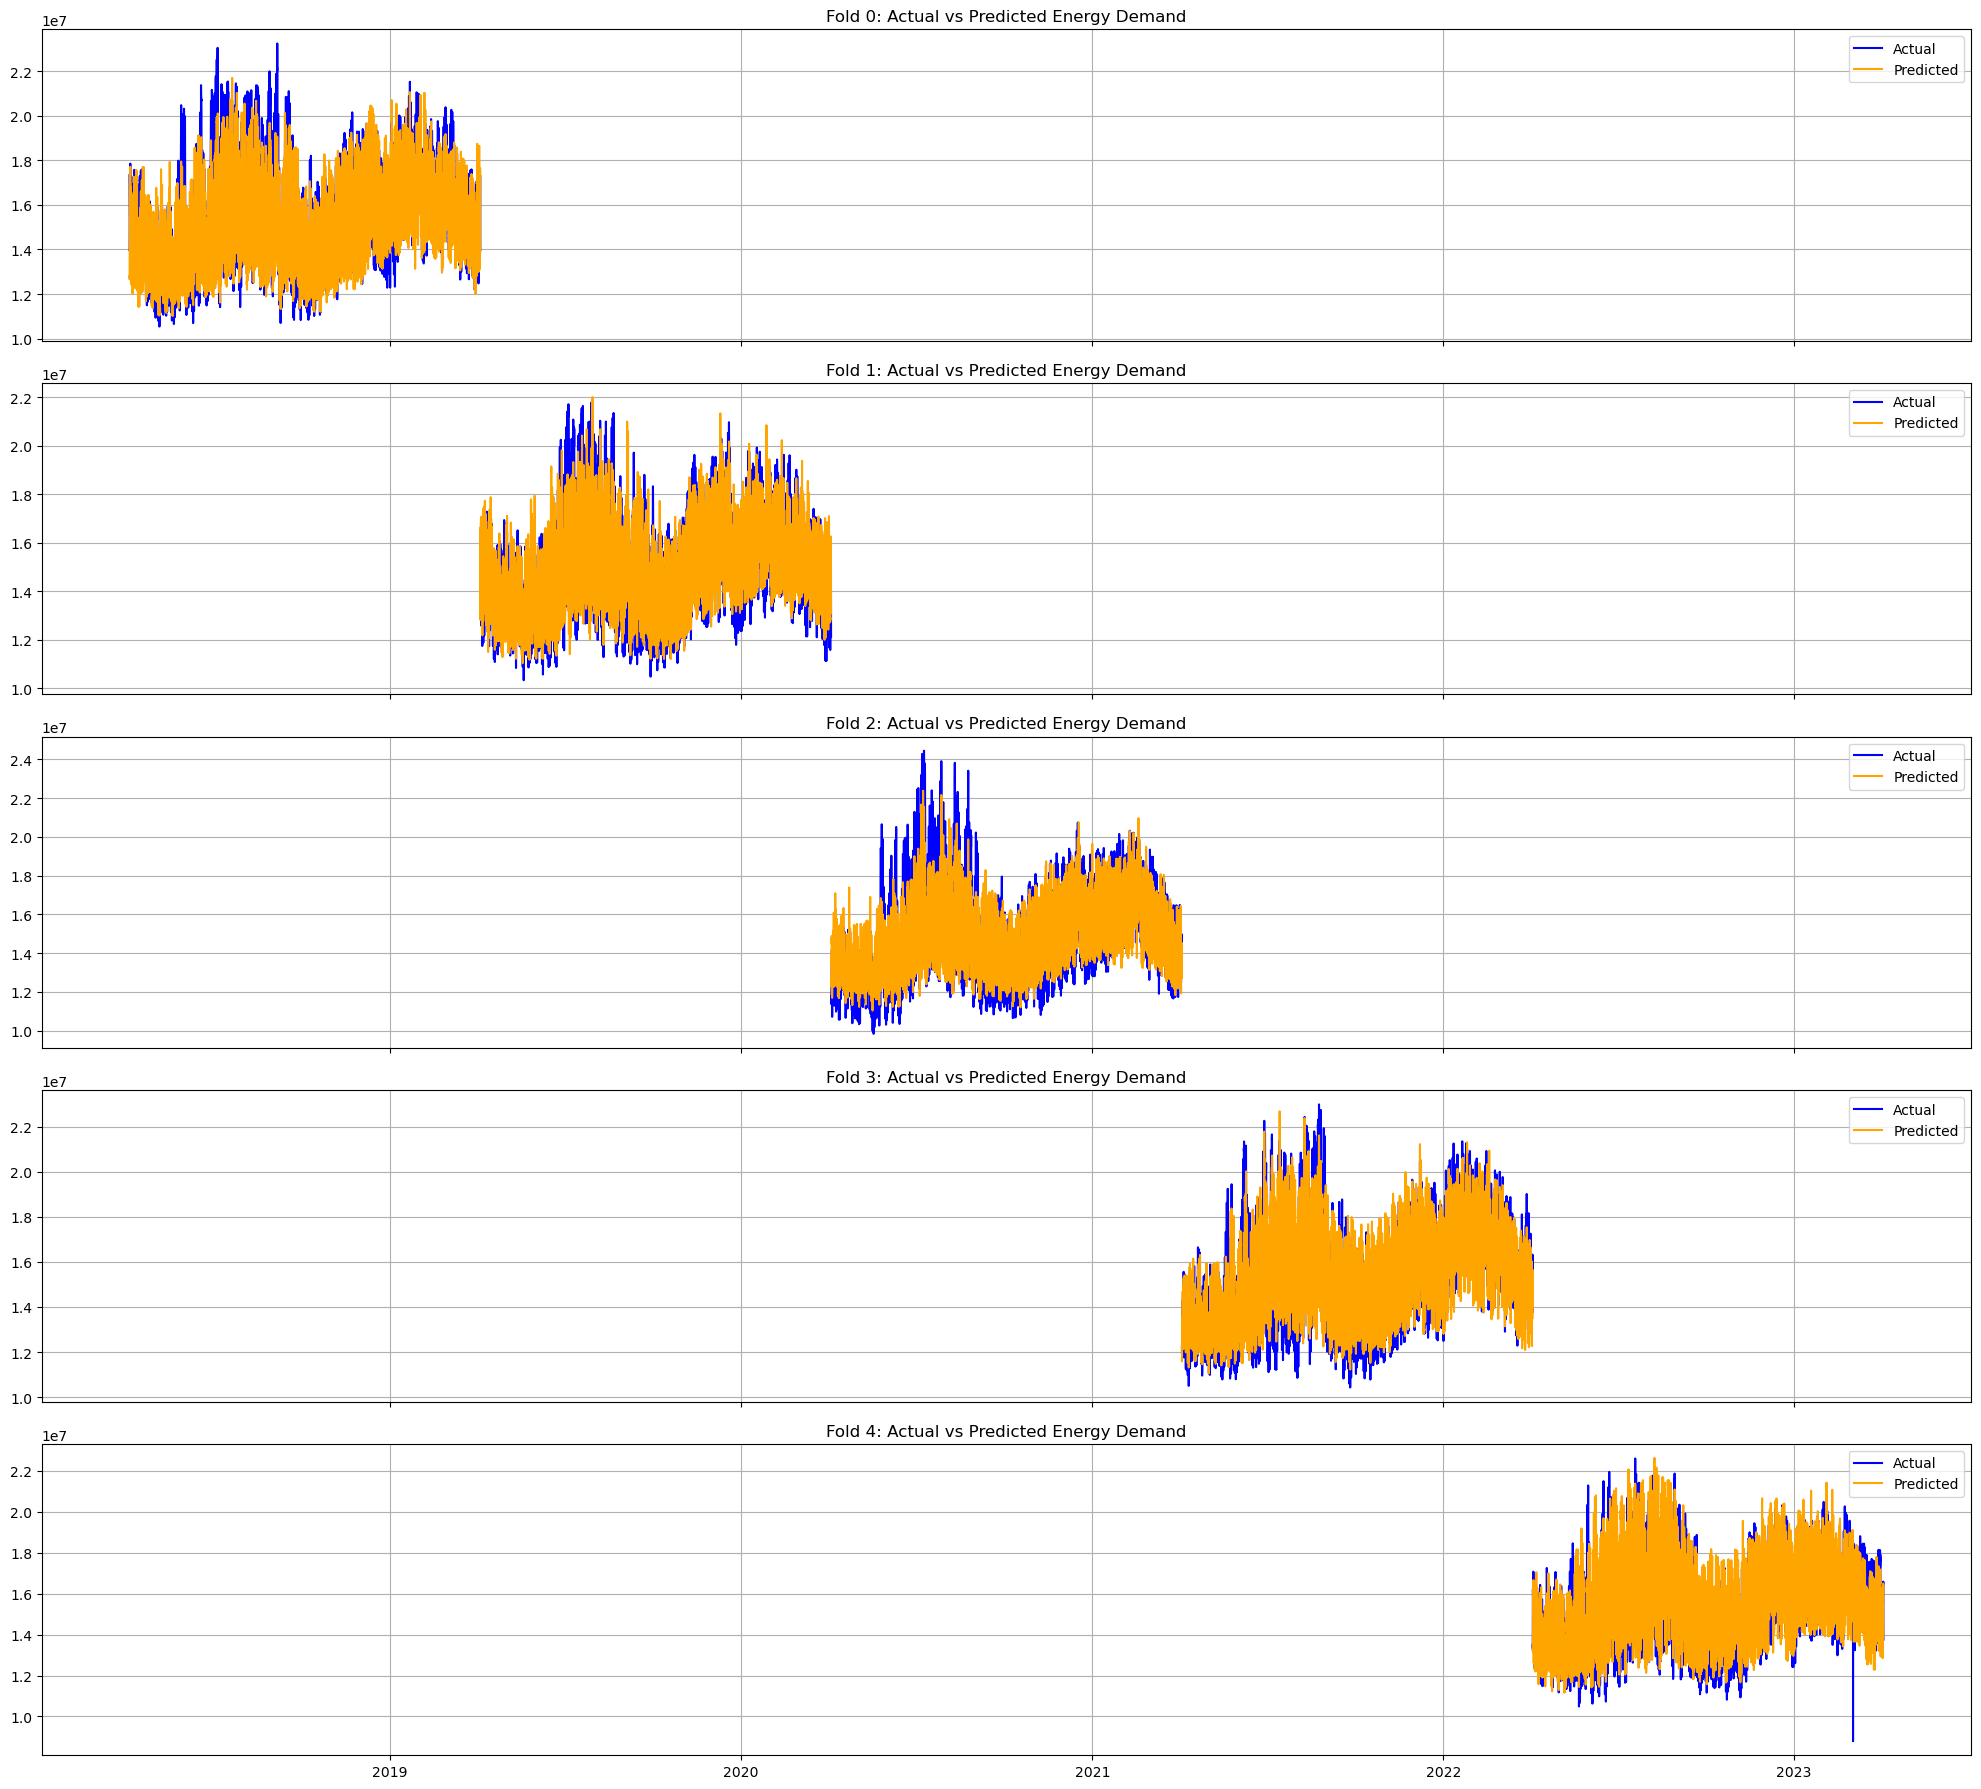

In [17]:
plot_actual_vs_predicted(df,reg)

## Function Documentation: `predict_future_demand(df, reg)`

### Purpose
Generates and visualizes future hourly energy demand predictions using a pre-trained XGBoost model, extending up to two years beyond the existing dataset.

### How It Works
1. **Generates a Future Time Range**:
   - Creates a datetime index from `'2023-04-03'` to `'2025-04-03'` with hourly frequency.
2. **Creates a Future DataFrame**:
   - Assigns the new datetime index to `future_df` and tags it with `isFuture=True`.
3. **Combines with Historical Data**:
   - Adds a column `isFuture=False` to the historical dataframe.
   - Concatenates historical and future data into a single DataFrame.
4. **Feature Engineering**:
   - Applies `create_features()` and `add_lags()` to ensure the future rows have required inputs.
5. **Prediction**:
   - Extracts only future rows using `query('isFuture')`.
   - Applies the trained model `reg.predict()` using the full feature list.
6. **Visualization**:
   - Plots the predicted demand (`pred`) from 2023 to 2025.

### What to Look For
- General trend of forecasted demand: increasing, decreasing, or seasonal.
- Irregular spikes or drops that may indicate model sensitivity.
- Smoothness and realism of long-range forecasts.

### Insights
- Allows planners to anticipate energy requirements up to 2 years ahead.
- Shows the model's ability to generalize to unseen data.
- Can be used to inform infrastructure, pricing, or policy decisions.

---

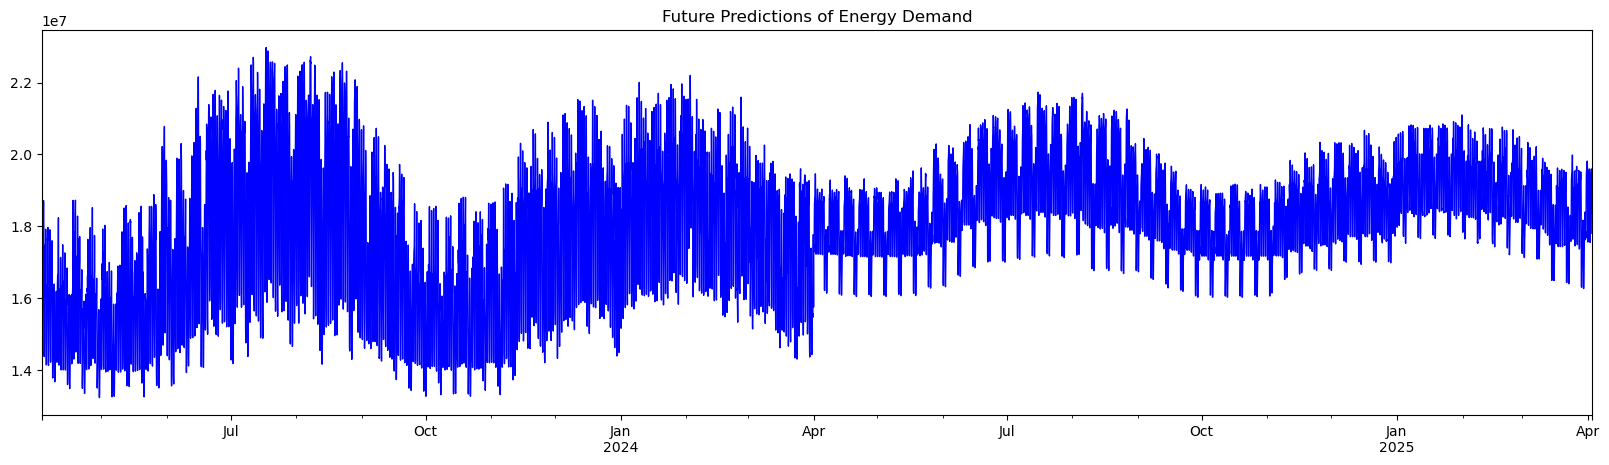

In [19]:
predict_future_demand(df,reg)

## Function Documentation: `plot_seasonal_energy_demand(df)`

### Purpose
Visualizes the average hourly energy demand across the four seasons to identify how energy consumption varies throughout the year.

### How It Works
1. **Preprocessing**:
   - Parses the `datetime` column into proper datetime objects.
   - Sets the datetime column as the index.
   - Removes duplicate timestamps and rows with missing `hourly_demand` values.

2. **Assigns Seasons**:
   - Maps months to meteorological seasons:
     - Winter: Dec, Jan, Feb
     - Spring: Mar, Apr, May
     - Summer: Jun, Jul, Aug
     - Fall: Sep, Oct, Nov

3. **Calculates Seasonal Averages**:
   - Groups the data by season and calculates the mean `hourly_demand` for each.

4. **Plots the Results**:
   - Displays the seasonal averages in a bar chart.
   - Uses consistent seasonal order: Winter → Spring → Summer → Fall.

### What to Look For
- Which season has the highest and lowest average energy demand.
- Seasonal patterns that may be linked to heating/cooling needs.
- Differences between transitional seasons (Spring/Fall) and extreme seasons (Winter/Summer).

### Insights
- Helps confirm that energy demand peaks in cold or hot seasons.
- Useful for capacity planning and energy grid management.
- Can validate model assumptions about seasonality.

---



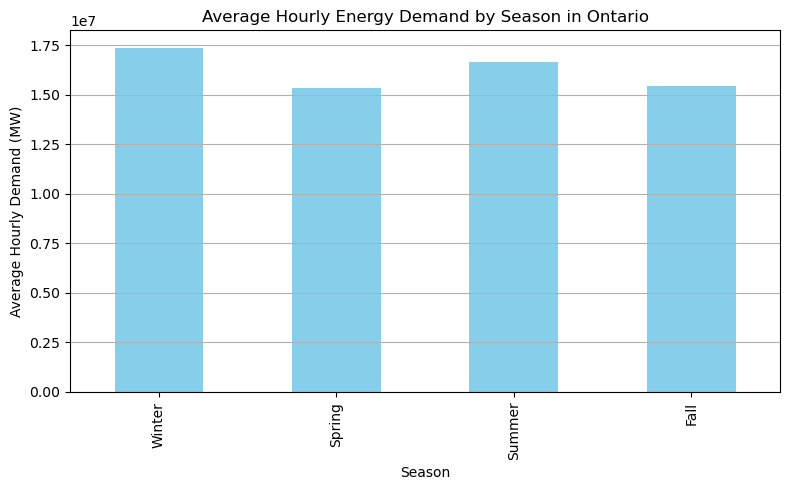

In [21]:
plot_seasonal_energy_demand(df)

## Function Documentation: `explore_data(data)`

### Purpose
The `explore_data` function provides an overview of the dataset's structure, statistics, and missing values. It helps in understanding the data before performing analysis or modeling.

### How It Works
1. **Prints Column Sample Rows**: Displays the first few rows of the dataset using `print(data.head())`.
2. **Prints Data Structure**: Uses `print(data.info())` to show column names, data types, and non-null counts.
3. **Displays Statistical Summary**: Calls `print(data.describe())` to present summary statistics for numerical columns.
4. **Checks for Missing Values**: Uses `print(data.isnull().sum())` to display the count of missing values per column.

### What to Look For
- Ensure that the dataset contains the expected columns and data types.
- Identify missing values and outliers that may require preprocessing.
- Verify that numerical features have meaningful statistics (e.g., no extreme outliers).

### Insights
- Helps assess data completeness and structure before analysis.
- Identifies columns that may need transformations, scaling, or imputation.
- Provides a quick snapshot of dataset distribution and variability.

---

In [14]:

explore_data(df)


Columns exist with sample rows data:
                          datetime  hourly_demand  hourly_average_price  \
date                                                                      
2003-01-01 00:00:00  1/1/2003 0:00       15205000                 26.65   
2003-01-01 01:00:00  1/1/2003 1:00       14745000                 27.21   
2003-01-01 02:00:00  1/1/2003 2:00       14280000                 26.71   
2003-01-01 03:00:00  1/1/2003 3:00       13821000                 26.91   
2003-01-01 04:00:00  1/1/2003 4:00       13239000                 23.92   

                     population  Temp (°C)  Dew Point Temp (°C)  Rel Hum (%)  \
date                                                                           
2003-01-01 00:00:00    12155691      -0.10                -3.47        78.00   
2003-01-01 01:00:00    12155691      -0.10                -4.33        73.67   
2003-01-01 02:00:00    12155691      -0.20                -4.60        73.00   
2003-01-01 03:00:00    12155691      


## Function Documentation: `plot_time_series(df)`

### Purpose
The `plot_time_series` function visualizes the energy demand over time to identify trends, seasonality, and anomalies in energy consumption.

### How It Works
1. **Creates a Plot**: Uses `plt.figure(figsize=(12, 6))` to set the figure size.
2. **Plots Energy Demand**: Uses `plt.plot(df.index, df['hourly_demand'], label='Energy Demand')` to plot demand over time.
3. **Adds Titles and Labels**: Sets `plt.title()`, `plt.xlabel()`, and `plt.ylabel()` for clarity.
4. **Displays Grid and Legend**: Enhances readability with `plt.legend()` and `plt.grid(True)`.
5. **Shows the Plot**: Calls `plt.show()` to display the visualization.

### What to Look For
- Long-term trends indicating increasing or decreasing energy demand.
- Seasonal patterns, such as daily, weekly, or yearly cycles.
- Sudden spikes or drops that may indicate anomalies or external influences.

### Insights
- Identifies peak consumption periods and potential seasonal variations.
- Helps in forecasting energy demand by recognizing repeating trends.
- Useful for detecting outliers that may require further investigation.

---

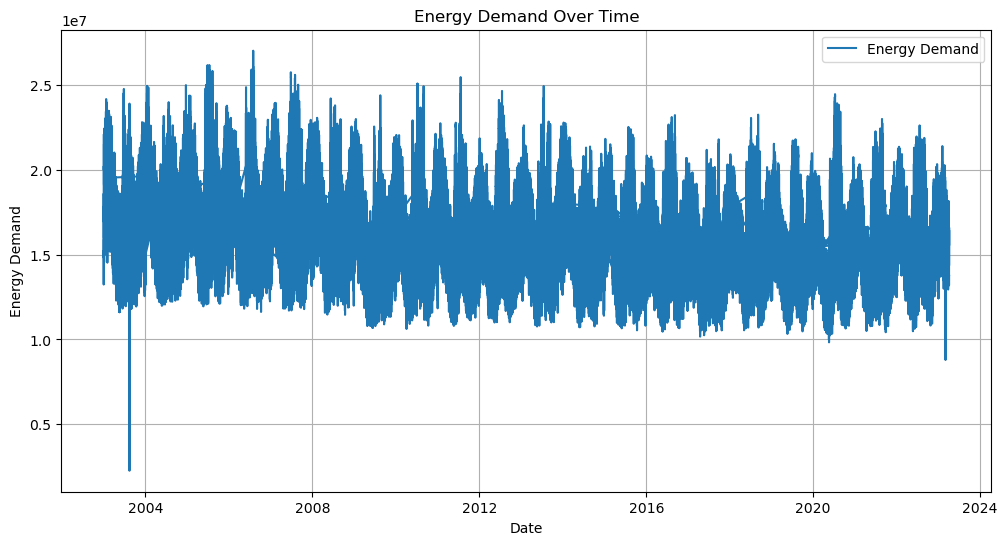

In [16]:
plot_time_series(df)


## Function Documentation: `plot_price_over_time(df)`

### Purpose
The `plot_price_over_time` function visualizes the hourly energy price over time, helping to identify trends, volatility, and anomalies in pricing.

### How It Works
1. **Creates a Plot**: Uses `plt.figure(figsize=(12, 6))` to define the plot size.
2. **Plots Energy Price**: Uses `plt.plot(df.index, df['hourly_average_price'], label='Hourly Average Price', color='orange')` to visualize price changes over time.
3. **Adds Titles and Labels**: Uses `plt.title()`, `plt.xlabel()`, and `plt.ylabel()` for clarity.
4. **Displays Grid and Legend**: Enhances readability with `plt.legend()` and `plt.grid(True)`.
5. **Shows the Plot**: Calls `plt.show()` to render the graph.

### What to Look For
- Price fluctuations and overall trends (rising, falling, or cyclical behavior).
- Periods of price spikes that may indicate peak demand or external market influences.
- Sudden price drops that could signal market disruptions or policy changes.

### Insights
- Helps in detecting periods of high and low energy prices for cost analysis.
- Can be used to understand how energy pricing responds to demand fluctuations.
- Useful for forecasting price trends and identifying potential anomalies in energy markets.

---

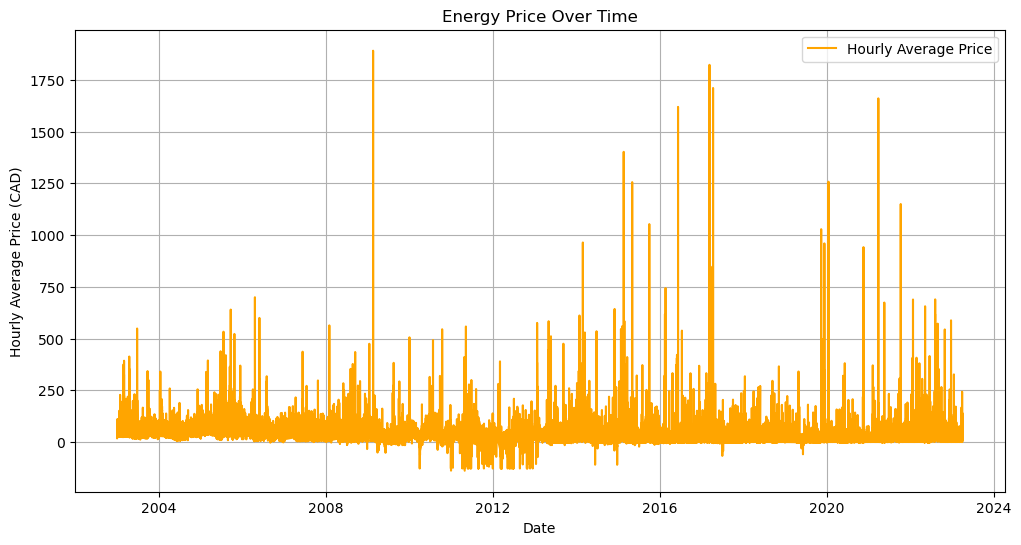

In [18]:
plot_price_over_time(df)


## Function Documentation: `plot_decomposition(df)`

### Purpose
The `plot_decomposition` function performs a seasonal decomposition of energy demand data to separate it into trend, seasonality, and residual components.

### How It Works
1. **Performs Seasonal Decomposition**: Uses `seasonal_decompose(df['hourly_demand'], model='multiplicative', period=24)` to break the time series into components.
   - `trend`: The underlying trend in energy demand.
   - `seasonal`: Repeating patterns due to daily cycles (24-hour period).
   - `residual`: The noise or unexplained variations.
2. **Plots the Decomposed Components**: Uses `result.plot()` to visualize the trend, seasonality, and residual components.
3. **Displays the Plot**: Calls `plt.show()` to render the visualization.

### What to Look For
- **Trend Line**: Observe if energy demand is increasing, decreasing, or stable over time.
- **Seasonal Pattern**: Identify daily, weekly, or other periodic fluctuations.
- **Residual Component**: Look for anomalies or unexpected variations that may indicate outliers.

### Insights
- Helps in understanding how different factors contribute to energy demand changes.
- Useful for preparing data for time-series forecasting models like ARIMA or SARIMA.
- Highlights anomalies that may be due to external influences, such as weather changes or market shifts.

---

 investigation.

---

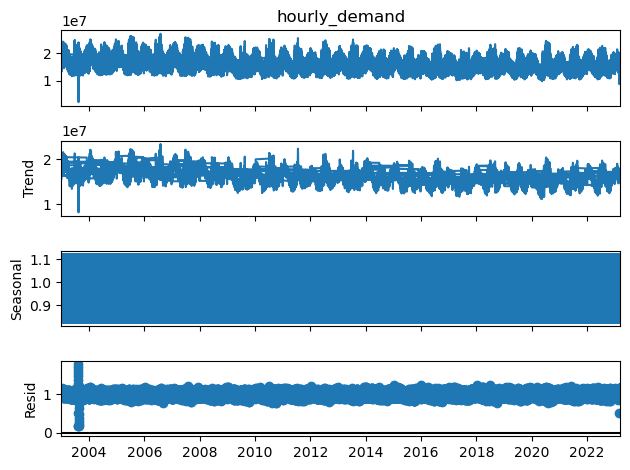

In [20]:
plot_decomposition(df)


## Function Documentation: `plot_correlation_matrix(df)`

### Purpose
The `plot_correlation_matrix` function generates a heatmap to visualize correlations between numerical features in the dataset, including climate, energy, and population data.

### How It Works
1. **Selects Numeric Columns**: Uses `df.select_dtypes(include=[np.number])` to extract only numeric data for correlation analysis.
2. **Computes Correlation Matrix**: Uses `.corr()` to calculate Pearson correlations between all numeric columns.
3. **Creates a Heatmap**: Uses `sns.heatmap()` to visualize the correlation matrix with:
   - `annot=True`: Displays correlation values within the heatmap.
   - `cmap='coolwarm'`: Uses a diverging color scheme to highlight strong positive/negative correlations.
   - `fmt='.2f'`: Rounds correlation values to two decimal places.
4. **Displays the Heatmap**: Uses `plt.show()` to render the visualization.

### What to Look For
- **High Correlations (Close to 1 or -1)**: Identify strong relationships between variables (e.g., temperature vs. energy demand).
- **Weak Correlations (Close to 0)**: Indicate little or no linear relationship between variables.
- **Unexpected Relationships**: Detect anomalies or patterns that require further investigation.

### Insights
- Helps in **feature selection** by identifying redundant variables.
- Highlights relationships between **climate factors and energy demand**, aiding in predictive modeling.
- Supports understanding of how **population growth affects energy consumption** over time.

---



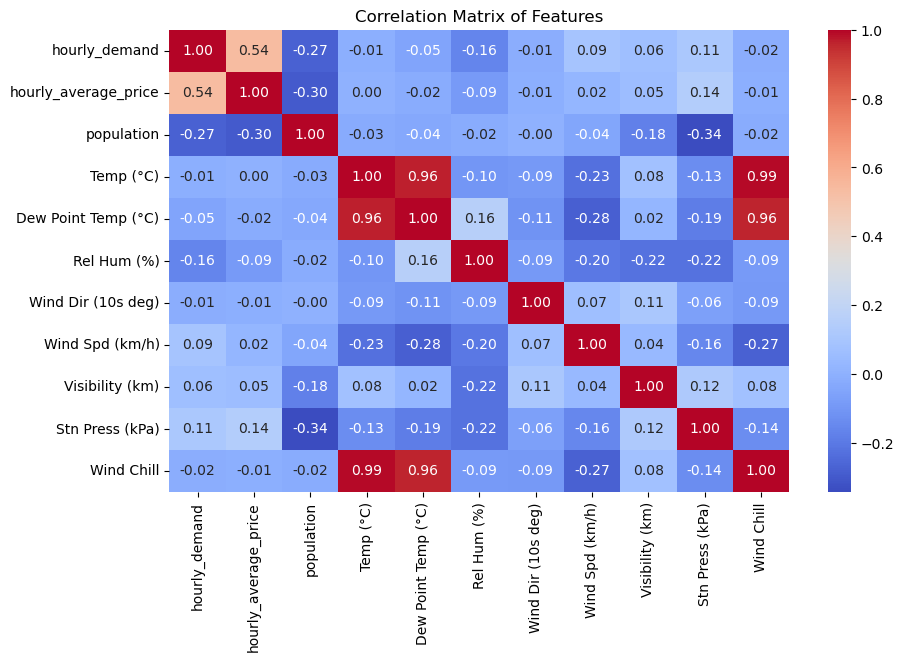

In [21]:
plot_correlation_matrix(df)


## Function Documentation: `plot_histograms(merged_df, columns)`

### Purpose
The `plot_histograms` function generates histograms for selected numerical columns to visualize their distributions, helping to analyze the spread, skewness, and potential outliers in the data.

### How It Works
1. **Creates a Figure**: Uses `plt.figure(figsize=(12, 5))` to set the figure size.
2. **Loops Over Selected Columns**:
   - Iterates over `columns` using `enumerate()`.
   - Uses `plt.subplot(1, len(columns), i + 1)` to arrange multiple histograms in a single row.
   - Calls `sns.histplot(merged_df[col], bins=20, kde=True, color='blue')` to plot the histogram with:
     - `bins=20`: Specifies the number of bins for better granularity.
     - `kde=True`: Adds a Kernel Density Estimate (KDE) curve for smooth distribution representation.
     - `color='blue'`: Sets the bar color for visualization.
3. **Adds Labels and Titles**: Sets `plt.xlabel(col)` and `plt.title(f'Distribution of {col}')` for clarity.
4. **Adjusts Layout and Displays**: Uses `plt.tight_layout()` to optimize spacing and `plt.show()` to render the histograms.

### What to Look For
- **Shape of the Distribution**: Identify normal, skewed, or multimodal distributions.
- **Outliers**: Detect extreme values that may require handling.
- **Spread of Data**: Understand the range and variance of the selected features.

### Insights
- Helps in detecting **data imbalance** and **skewness**, which may require transformations.
- Provides insights into how **energy demand, temperature, and population** are distributed.
- Useful for **feature selection and scaling** before applying machine learning models.

---

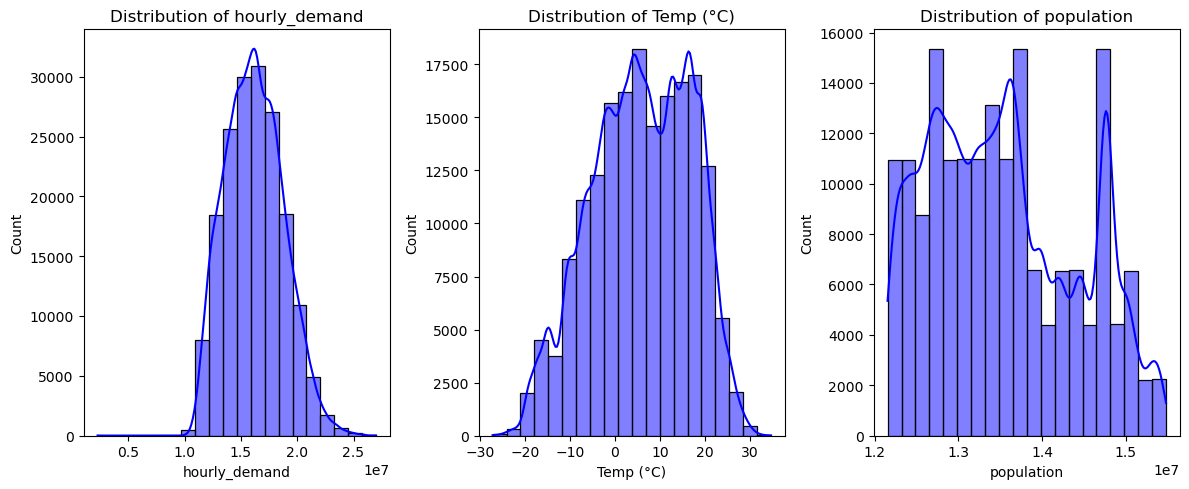

In [93]:
plot_histograms(df, ['hourly_demand','Temp (°C)','population'])


## Function Documentation: `plot_population_trend(merged_df)`

### Purpose
The `plot_population_trend` function visualizes the growth of Ontario's population over time, helping to analyze demographic trends and their potential impact on energy demand.

### How It Works
1. **Creates a Figure**: Uses `plt.figure(figsize=(10, 5))` to define the plot size.
2. **Plots Population Over Time**:
   - Uses `plt.plot(merged_df.index, merged_df['population'], marker='o', linestyle='-')` to create a line plot with circular markers.
   - The `index` (time) is set as the x-axis, and the `population` column is plotted on the y-axis.
3. **Adds Labels and Titles**: Sets `plt.xlabel('Year')`, `plt.ylabel('Population')`, and `plt.title('Ontario Population Over Time')`.
4. **Enhances Readability**: Uses `plt.grid(True)` to add grid lines.
5. **Displays the Plot**: Calls `plt.show()` to render the visualization.

### What to Look For
- **Overall Growth Trend**: Observe whether the population is increasing, decreasing, or stabilizing over time.
- **Sudden Changes**: Identify sharp increases or decreases that may indicate demographic shifts.
- **Cyclical Patterns**: Check for seasonal or periodic variations in population data (if applicable).

### Insights
- Helps in **long-term planning** by understanding population growth trends.
- Provides context for **energy consumption forecasts**, as population growth often correlates with higher energy demand.
- Useful for **government and infrastructure planning** to meet future energy needs.

---

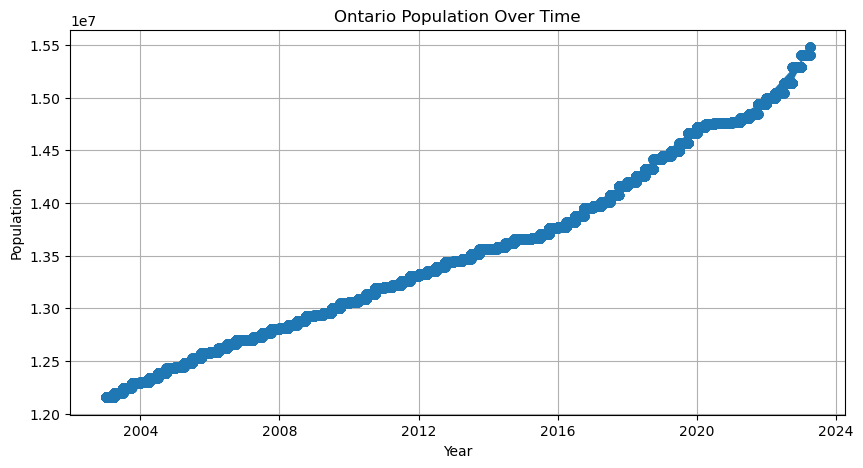

In [45]:
plot_population_trend(df)


## Function Documentation: `plot_energy_vs_population(merged_df)`

### Purpose
The `plot_energy_vs_population` function generates a scatter plot to analyze the relationship between population size and energy demand.

### How It Works
1. **Creates a Figure**: Uses `plt.figure(figsize=(8, 5))` to define the plot size.
2. **Generates Scatter Plot**:
   - Uses `sns.scatterplot(x=merged_df['population'], y=merged_df['hourly_demand'])` to plot population against energy demand.
   - The `population` column is set as the x-axis, and `hourly_demand` is plotted on the y-axis.
3. **Adds Labels and Titles**: Sets `plt.xlabel('Population')`, `plt.ylabel('Energy Demand')`, and `plt.title('Population vs. Energy Demand')`.
4. **Enhances Readability**: Uses `plt.grid(True)` to add grid lines.
5. **Displays the Plot**: Calls `plt.show()` to render the visualization.

### What to Look For
- **Correlation**: Determine if there is a positive or negative relationship between population and energy demand.
- **Clusters of Data**: Identify whether different population levels correspond to distinct energy consumption behaviors.
- **Outliers**: Detect extreme values that may indicate anomalies in energy usage patterns.

### Insights
- Helps in **forecasting energy demand** based on population growth trends.
- Provides insights into **regional energy consumption patterns**.
- Supports **infrastructure planning** by identifying areas of high energy demand growth.

---

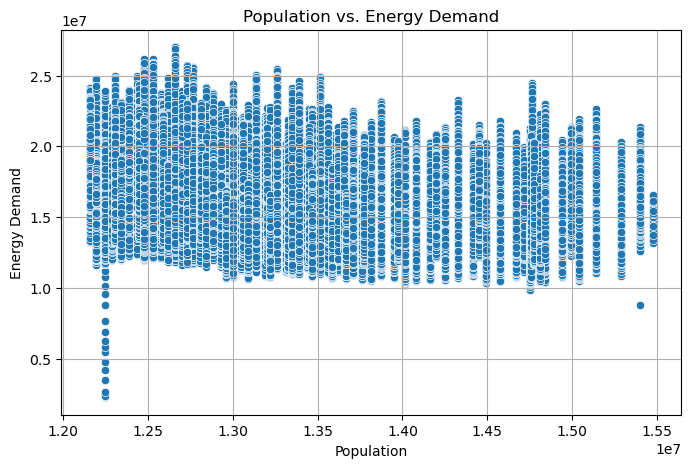

In [51]:
plot_energy_vs_population(df)


## Function Documentation: `plot_temperature_trends(df_climate)`

### Purpose
The `plot_temperature_trends` function visualizes temperature variations over time, helping to identify seasonal patterns and extreme weather conditions.

### How It Works
1. **Creates a Figure**: Uses `plt.figure(figsize=(12, 6))` to set the plot size.
2. **Plots Temperature Data**:
   - Uses `plt.plot(df_climate.index, df_climate['Temp (°C)'], label='Temperature', color='red')` to display temperature trends.
   - The x-axis represents time (`index`), while the y-axis represents temperature in degrees Celsius.
3. **Adds Labels and Titles**:
   - `plt.xlabel('Date')` and `plt.ylabel('Temperature (°C)')` to describe axes.
   - `plt.title('Temperature Trends Over Time')` to provide context.
4. **Enhances Readability**:
   - Uses `plt.legend()` to label the temperature line.
   - Adds `plt.grid(True)` for better visualization.
5. **Displays the Plot**: Calls `plt.show()` to render the visualization.

### What to Look For
- **Seasonal Trends**: Identify recurring temperature patterns across months or years.
- **Temperature Spikes or Drops**: Detect extreme weather events that might impact energy demand.
- **Gradual Shifts**: Observe long-term temperature trends, such as global warming effects.

### Insights
- Helps in **climate impact analysis** by identifying temperature fluctuations over time.
- Supports **energy demand forecasting**, as temperature significantly affects energy usage.
- Useful for **correlating weather conditions** with energy consumption patterns.

---

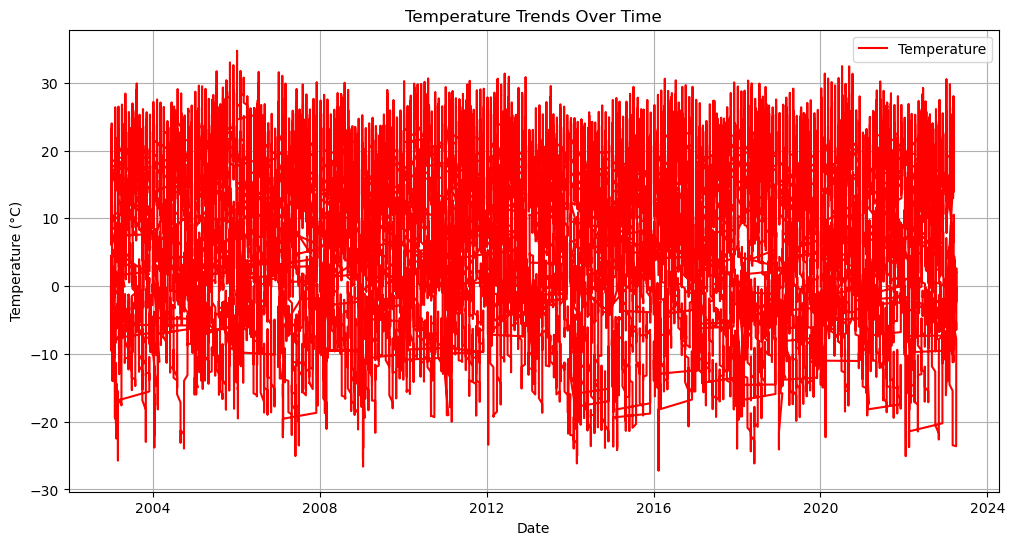

In [53]:
plot_temperature_trends(df)


## Function Documentation: `plot_wind_chill_trends(df)`

### Purpose
The `plot_wind_chill_trends` function visualizes wind chill temperature variations over time, highlighting how "feels-like" temperatures fluctuate with wind speed.

### How It Works
1. **Creates a Figure**: Uses `plt.figure(figsize=(12, 6))` to define the plot size.
2. **Plots Wind Chill Data**:
   - Uses `plt.plot(df.index, df['Wind Chill'], label='Wind Chill', color='cyan')` to display wind chill temperature trends.
   - The x-axis represents time (`index`), while the y-axis represents wind chill in degrees Celsius.
3. **Adds Labels and Titles**:
   - `plt.xlabel('Date')` and `plt.ylabel('Wind Chill (°C)')` to describe axes.
   - `plt.title('Wind Chill Trends Over Time')` for context.
4. **Enhances Readability**:
   - Uses `plt.legend()` to label the wind chill line.
   - Adds `plt.grid(True)` for better visualization.
5. **Displays the Plot**: Calls `plt.show()` to render the visualization.

### What to Look For
- **Cold Weather Events**: Identify extreme wind chill periods that could impact energy demand.
- **Seasonal Patterns**: Observe recurring trends in wind chill, particularly in winter months.
- **Abrupt Changes**: Detect sudden shifts in "feels-like" temperature due to high wind speeds.

### Insights
- Helps in **weather impact analysis**, particularly for understanding extreme cold conditions.
- Supports **energy demand forecasting**, as lower wind chill temperatures may increase heating needs.
- Useful for **climate monitoring**, helping identify changes in wind chill trends over the years.

---



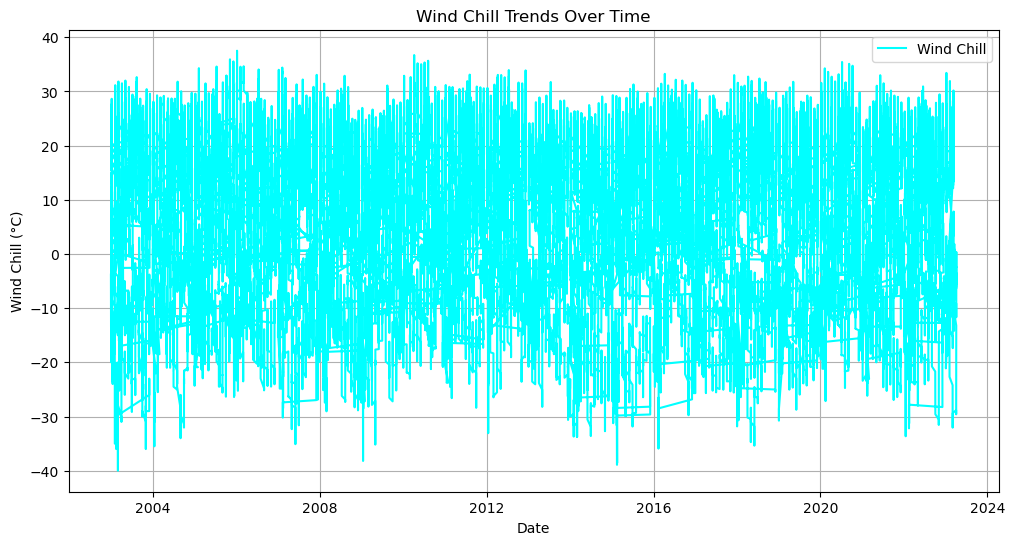

In [111]:
plot_wind_chill_trends(df)

## Function Documentation: `plot_humidity_trends(df_climate)`

### Purpose
The `plot_humidity_trends` function visualizes the relative humidity trends over time, helping to analyze moisture variations and their potential impact on climate and energy demand.

### How It Works
1. **Creates a Figure**: Uses `plt.figure(figsize=(12, 6))` to define the plot size.
2. **Plots Humidity Data**:
   - Uses `plt.plot(df_climate.index, df_climate['Rel Hum (%)'], label='Relative Humidity', color='blue')` to display humidity trends.
   - The x-axis represents time (`index`), while the y-axis represents relative humidity in percentage.
3. **Adds Labels and Titles**:
   - `plt.xlabel('Date')` and `plt.ylabel('Relative Humidity (%)')` to describe axes.
   - `plt.title('Humidity Trends Over Time')` to provide context.
4. **Enhances Readability**:
   - Uses `plt.legend()` to label the humidity line.
   - Adds `plt.grid(True)` for better visualization.
5. **Displays the Plot**: Calls `plt.show()` to render the visualization.

### What to Look For
- **Seasonal Changes**: Identify recurring patterns in humidity levels across different months.
- **Extreme Moisture Levels**: Detect periods of high or low humidity that may affect energy usage.
- **Abrupt Changes**: Observe sudden shifts in humidity that may indicate weather events like storms or droughts.

### Insights
- Helps in **climate trend analysis**, identifying long-term humidity variations.
- Supports **energy demand forecasting**, as humidity levels influence heating and cooling requirements.
- Useful for **weather impact studies**, helping correlate humidity with other climate factors like temperature and wind speed.

---

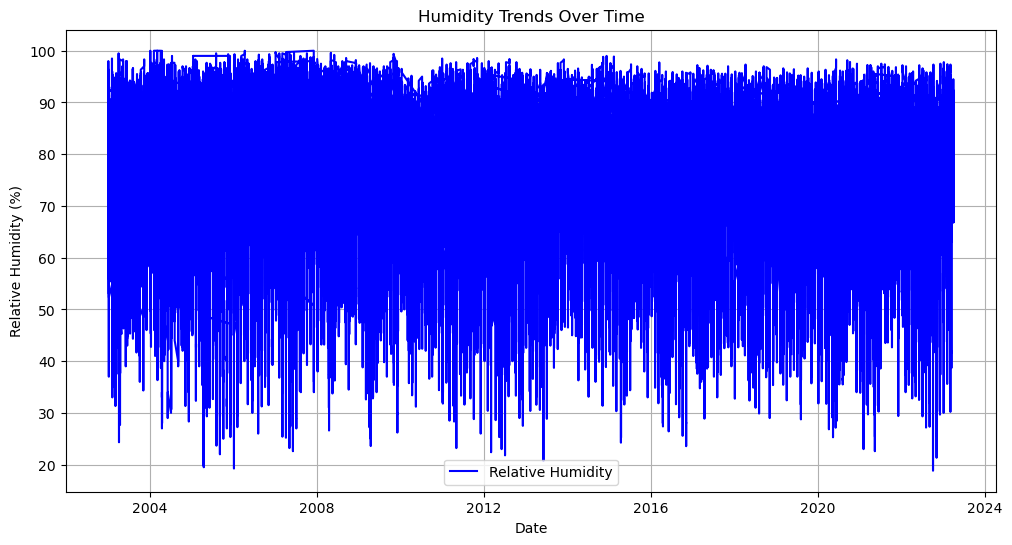

In [55]:
plot_humidity_trends(df)


## Function Documentation: `plot_wind_speed_vs_energy(df)`

### Purpose
The `plot_wind_speed_vs_energy` function generates a scatter plot to analyze the relationship between wind speed and energy demand.

### How It Works
1. **Creates a Figure**: Uses `plt.figure(figsize=(12, 6))` to define the plot size.
2. **Generates Scatter Plot**:
   - Uses `plt.scatter(df['Wind Spd (km/h)'], df['hourly_demand'], alpha=0.5, color='green')` to plot wind speed against energy demand.
   - The `Wind Spd (km/h)` column is set as the x-axis, while `hourly_demand` is plotted on the y-axis.
3. **Adds Labels and Titles**:
   - `plt.xlabel('Wind Speed (km/h)')` and `plt.ylabel('Energy Demand')` to describe axes.
   - `plt.title('Energy Demand vs Wind Speed')` to provide context.
4. **Enhances Readability**:
   - Uses `plt.grid(True)` to add grid lines for better visualization.
5. **Displays the Plot**: Calls `plt.show()` to render the visualization.

### What to Look For
- **Correlation**: Check if wind speed has a positive, negative, or no correlation with energy demand.
- **Clusters of Data**: Identify if specific wind speed ranges are associated with higher or lower energy consumption.
- **Outliers**: Look for extreme values that may indicate unusual weather events impacting energy demand.

### Insights
- Helps in **renewable energy studies**, particularly for wind energy production and its effect on demand.
- Supports **energy demand forecasting**, as wind speed can influence heating and cooling needs.
- Useful for **climate impact analysis**, understanding how wind conditions affect energy consumption.

---

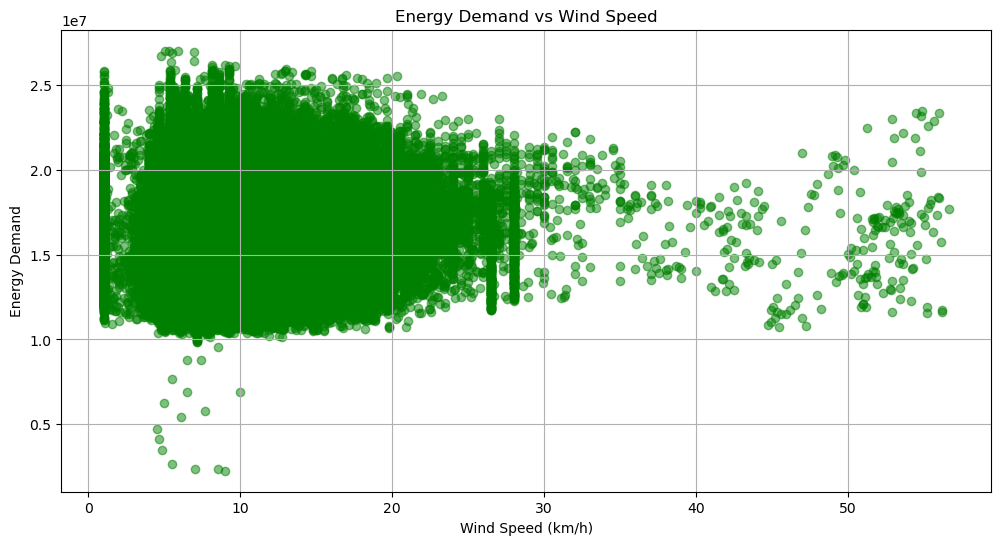

In [57]:
plot_wind_speed_vs_energy(df)

## Function Documentation: `plot_wind_speed_direction(df_climate)`

### Purpose
The `plot_wind_speed_direction` function generates a scatter plot to analyze the relationship between wind speed and wind direction.

### How It Works
1. **Creates a Figure**: Uses `plt.figure(figsize=(12, 6))` to define the plot size.
2. **Generates Scatter Plot**:
   - Uses `plt.scatter(df_climate['Wind Dir (10s deg)'], df_climate['Wind Spd (km/h)'], alpha=0.5, color='green')` to plot wind direction against wind speed.
   - The `Wind Dir (10s deg)` column is set as the x-axis, while `Wind Spd (km/h)` is plotted on the y-axis.
3. **Adds Labels and Titles**:
   - `plt.xlabel('Wind Direction (Degrees)')` and `plt.ylabel('Wind Speed (km/h)')` to describe axes.
   - `plt.title('Wind Speed vs. Wind Direction')` to provide context.
4. **Enhances Readability**:
   - Uses `plt.grid(True)` to add grid lines for better visualization.
5. **Displays the Plot**: Calls `plt.show()` to render the visualization.

### What to Look For
- **Wind Patterns**: Identify common wind directions associated with high or low wind speeds.
- **Clusters of Data**: Observe if specific wind directions tend to have more frequent or extreme wind speeds.
- **Outliers**: Detect unusual wind conditions that may impact energy demand or climate effects.

### Insights
- Helps in **wind energy analysis**, understanding how wind direction affects speed and potential energy generation.
- Supports **weather impact studies**, identifying dominant wind patterns and their variations.
- Useful for **climate and meteorological research**, analyzing wind behavior across different seasons.

---



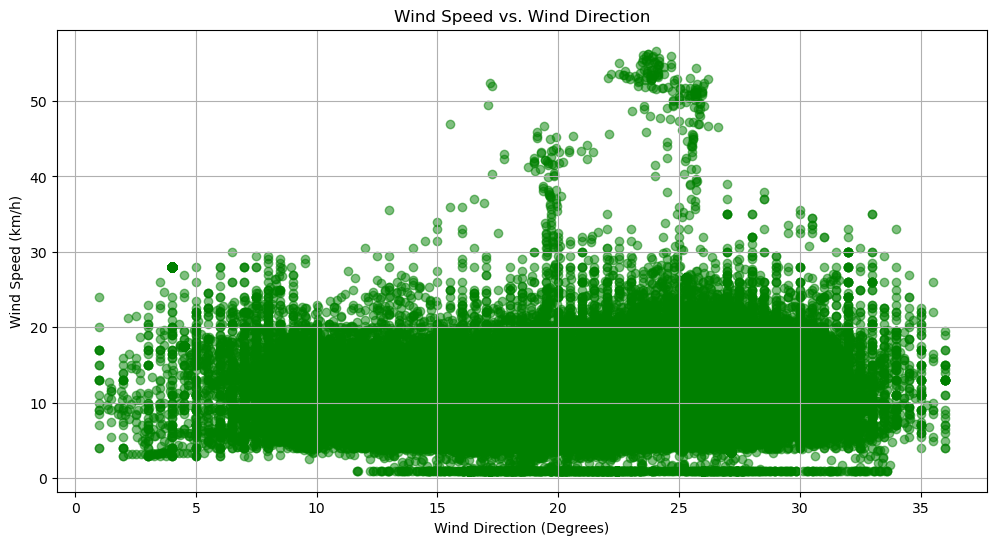

In [59]:
plot_wind_speed_direction(df)

## Function Documentation: `plot_pressure_variations(df_climate)`

### Purpose
The `plot_pressure_variations` function visualizes atmospheric pressure changes over time, helping to analyze weather patterns and their potential impact on climate and energy demand.

### How It Works
1. **Creates a Figure**: Uses `plt.figure(figsize=(12, 6))` to define the plot size.
2. **Plots Pressure Data**:
   - Uses `plt.plot(df_climate.index, df_climate['Stn Press (kPa)'], label='Station Pressure', color='purple')` to display pressure variations over time.
   - The x-axis represents time (`index`), while the y-axis represents pressure in kilopascals (kPa).
3. **Adds Labels and Titles**:
   - `plt.xlabel('Date')` and `plt.ylabel('Pressure (kPa)')` to describe axes.
   - `plt.title('Pressure Variations Over Time')` to provide context.
4. **Enhances Readability**:
   - Uses `plt.legend()` to label the pressure line.
   - Adds `plt.grid(True)` for better visualization.
5. **Displays the Plot**: Calls `plt.show()` to render the visualization.

### What to Look For
- **Weather Patterns**: Observe fluctuations in pressure related to changing weather conditions.
- **Storm Indicators**: Identify rapid pressure drops, which may indicate storm events.
- **Long-term Trends**: Detect gradual changes in atmospheric pressure that may reflect climate variations.

### Insights
- Helps in **weather forecasting**, as pressure variations are linked to different weather conditions.
- Supports **climate change analysis**, identifying trends in atmospheric pressure over time.
- Useful for **energy demand forecasting**, as pressure changes often correlate with temperature and wind variations affecting energy usage.

---



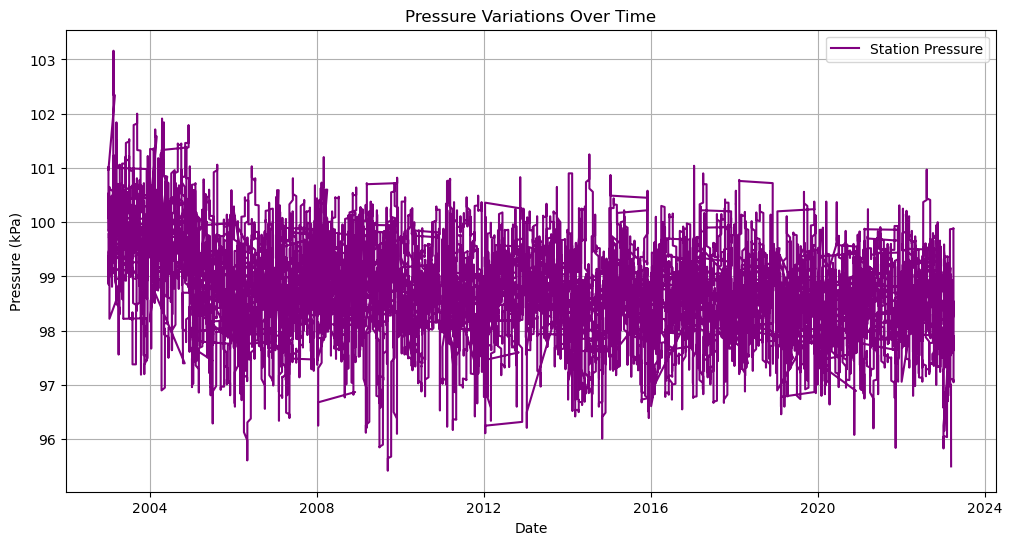

In [61]:
plot_pressure_variations(df)

## Function Documentation: `plot_cross_correlation(merged_df, lag_range=48)`

### Purpose
The `plot_cross_correlation` function analyzes the relationship between energy demand and temperature over different time lags, helping to understand how temperature influences energy consumption.

### How It Works
1. **Computes Cross-Correlation**:
   - Iterates over `range(-lag_range, lag_range)` to calculate Pearson correlation between `hourly_demand` and `Temp (°C)` shifted by different lags.
   - Stores the computed correlations in a list.
2. **Creates a Lag List**:
   - Generates a list of lag values ranging from `-lag_range` to `lag_range`.
3. **Plots Cross-Correlation**:
   - Uses `plt.plot(lags, cross_corr, marker='o')` to plot the lag vs. correlation values.
   - Adds `plt.axvline(x=0, color='black', linestyle='--')` to mark the zero lag position.
4. **Adds Labels and Titles**:
   - `plt.xlabel('Lag (hours)')` and `plt.ylabel('Correlation')` for axis descriptions.
   - `plt.title('Cross-Correlation between Energy Demand and Temperature')` for context.
5. **Enhances Readability**:
   - Uses `plt.grid(True)` to improve visualization.
6. **Displays the Plot**: Calls `plt.show()` to render the visualization.

### What to Look For
- **Peak Correlation Lags**: Identify time lags where temperature most strongly influences energy demand.
- **Negative vs. Positive Lags**: Compare how past vs. future temperature shifts correlate with energy consumption.
- **Correlation Strength**: Observe if temperature has a strong, moderate, or weak effect on energy demand.

### Insights
- Helps in **energy demand forecasting** by determining how long after a temperature change energy demand is affected.
- Supports **climate impact analysis**, identifying delays between weather fluctuations and energy usage.
- Useful for **grid management**, optimizing energy supply based on expected demand shifts.

---

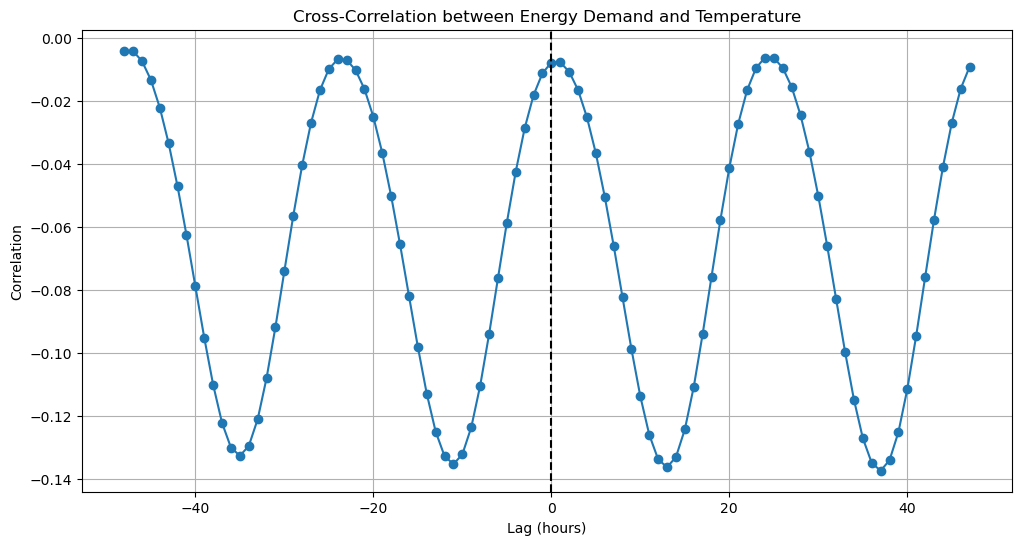

In [63]:
plot_cross_correlation(df)

## Function Documentation: `plot_rolling_statistics(df)`

### Purpose
The `plot_rolling_statistics` function visualizes the rolling mean and standard deviation of energy demand over time, helping to identify trends and variability in energy consumption.

### How It Works
1. **Computes Rolling Statistics**:
   - Uses `.rolling(window=30).mean()` to calculate a 30-hour rolling mean of `hourly_demand`.
   - Uses `.rolling(window=30).std()` to compute the rolling standard deviation.
2. **Creates a Figure**: Uses `plt.figure(figsize=(12, 6))` to define the plot size.
3. **Plots Original Demand and Rolling Statistics**:
   - `plt.plot(df.index, df['hourly_demand'], label='Original Energy Demand')` plots the original data.
   - `plt.plot(df.index, rolling_mean, label='30-Hour Rolling Mean', color='red')` visualizes the rolling mean.
   - `plt.plot(df.index, rolling_std, label='30-Hour Rolling Std Dev', color='green')` displays the rolling standard deviation.
4. **Adds Labels and Titles**:
   - `plt.xlabel('Date')` and `plt.ylabel('Energy Demand')` to describe axes.
   - `plt.title('Rolling Mean and Std Dev of Energy Demand')` to provide context.
5. **Enhances Readability**:
   - Uses `plt.legend()` to label the lines.
   - Uses `plt.show()` to display the visualization.

### What to Look For
- **Long-Term Trends**: Identify general increases or decreases in energy demand.
- **Seasonal Variations**: Observe periodic changes in demand.
- **Volatility**: Analyze fluctuations using the rolling standard deviation.

### Insights
- Helps in **trend detection** by smoothing short-term fluctuations.
- Useful for **stationarity tests**, as rolling statistics reveal changes over time.
- Supports **forecasting model preparation**, ensuring stable time series for modeling.

---

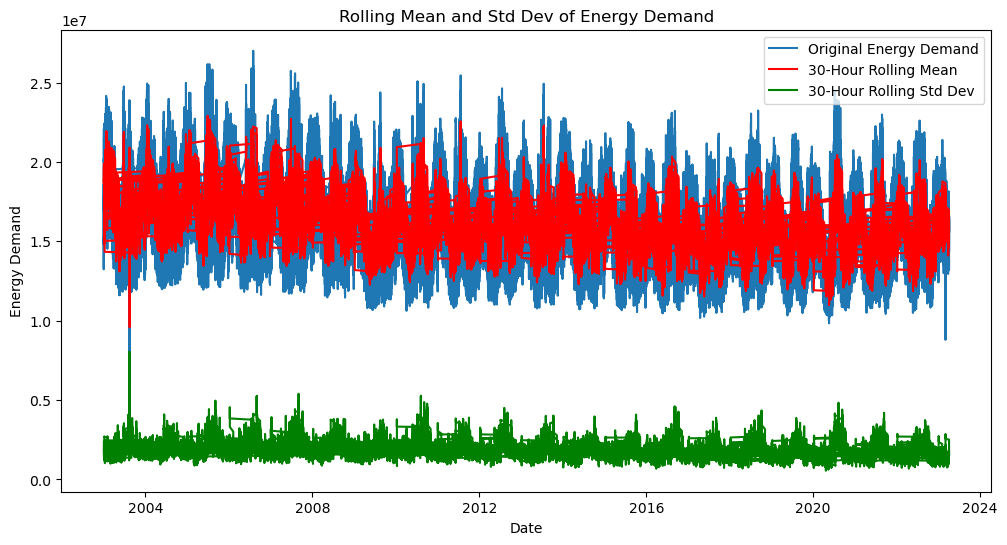

In [65]:
plot_rolling_statistics(df)

## Function Documentation: `plot_acf_pacf(df)`

### Purpose
The `plot_acf_pacf` function generates the Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) plots to analyze time-series dependencies and identify the order of ARIMA models.

### How It Works
1. **Creates a Figure**: Uses `plt.figure(figsize=(12, 6))` to define the plot size.
2. **Plots ACF**:
   - Uses `plot_acf(df['hourly_demand'], lags=50, ax=plt.gca())` to plot the autocorrelation up to 50 lags.
   - ACF measures how a time series is correlated with its past values.
3. **Plots PACF**:
   - Uses `plot_pacf(df['hourly_demand'], lags=50, ax=plt.gca())` to plot the partial autocorrelation.
   - PACF helps determine the direct relationship between a time series and its lagged values, removing intermediate effects.
4. **Displays the Plot**: Calls `plt.show()` to render the visualization.

### What to Look For
- **Significant Lags in ACF**: Identify the number of lags with high correlation, helping determine the MA (Moving Average) order.
- **Significant Lags in PACF**: Identify direct dependencies, which help determine the AR (Auto-Regressive) order.
- **Decay Patterns**:
  - Slow ACF decay suggests a non-stationary series.
  - Sharp PACF cutoff suggests an AR process, while sharp ACF cutoff suggests an MA process.

### Insights
- Helps in **time-series modeling**, particularly in selecting ARIMA parameters (`p`, `q`).
- Identifies **seasonality**, as periodic peaks in ACF may indicate repeating patterns.
- Useful for **stationarity checks**, revealing whether differencing is needed to stabilize the series.

---

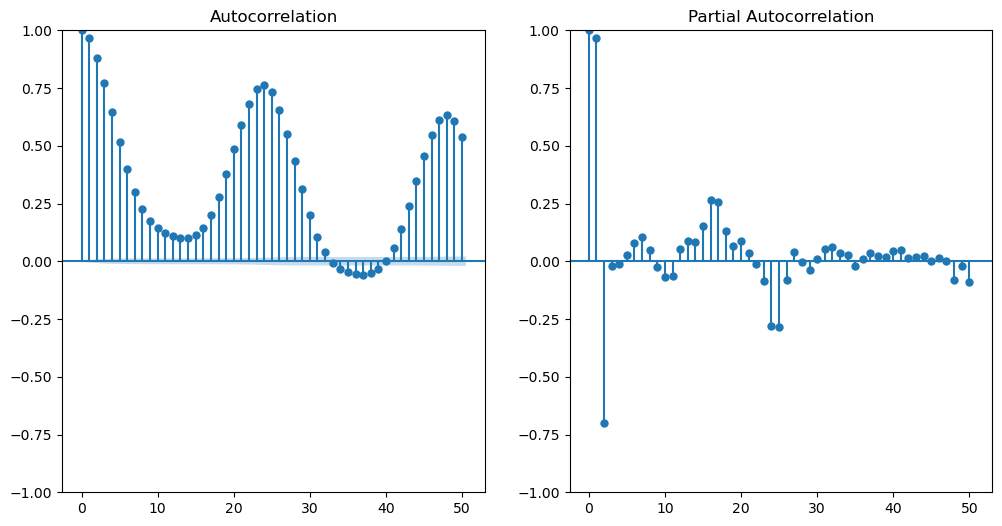

In [67]:
plot_acf_pacf(df)

## Function Documentation: `plot_demand_vs_price(df)`

### Purpose
The `plot_demand_vs_price` function generates a scatter plot to analyze the relationship between energy demand and hourly average price.

### How It Works
1. **Creates a Figure**: Uses `plt.figure(figsize=(12, 6))` to define the plot size.
2. **Generates Scatter Plot**:
   - Uses `plt.scatter(df['hourly_average_price'], df['hourly_demand'], alpha=0.6)` to plot price against demand.
   - The `hourly_average_price` column is set as the x-axis, while `hourly_demand` is plotted on the y-axis.
   - The `alpha=0.6` setting makes overlapping points more distinguishable.
3. **Adds Labels and Titles**:
   - `plt.xlabel('Hourly Average Price')` and `plt.ylabel('Energy Demand')` to describe axes.
   - `plt.title('Energy Demand vs Hourly Average Price')` to provide context.
4. **Displays the Plot**: Calls `plt.show()` to render the visualization.

### What to Look For
- **Correlation**: Identify whether higher prices correspond to higher or lower energy demand.
- **Clusters of Data**: Observe if demand varies significantly across different price levels.
- **Outliers**: Detect anomalies where demand does not follow expected price trends.

### Insights
- Helps in **market analysis**, understanding how pricing affects energy consumption.
- Supports **demand-response strategies**, identifying whether price incentives impact energy usage.
- Useful for **forecasting energy demand**, as price fluctuations influence consumer behavior.

---

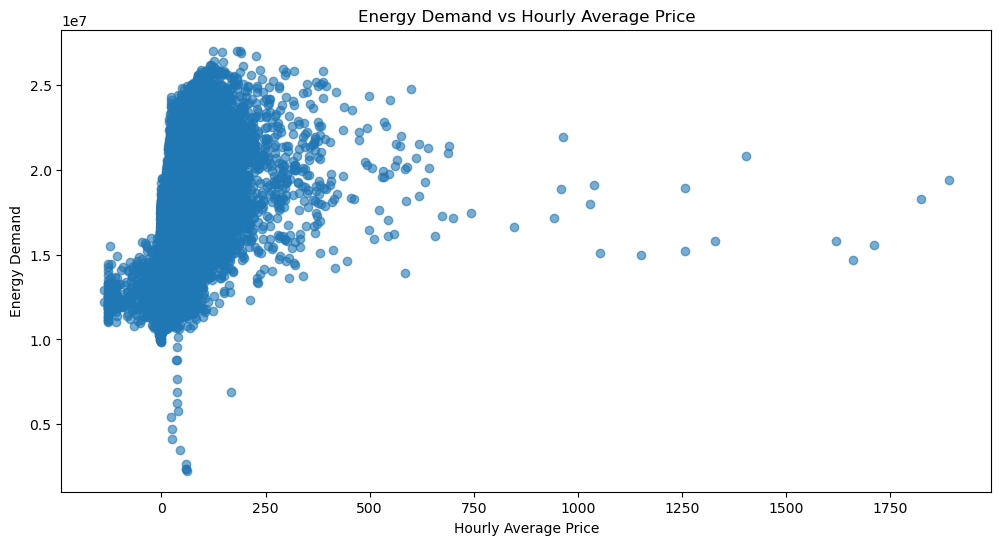

In [122]:
plot_demand_vs_price(df)

## Function Documentation: `plot_seasonal_patterns(df_climate)`

### Purpose
The `plot_seasonal_patterns` function visualizes seasonal variations in temperature by displaying the average monthly temperature over time.

### How It Works
1. **Extracts the Month from the Date Index**:
   - Creates a new column `df_climate['month'] = df_climate.index.month` to extract the month from the datetime index.
2. **Computes Monthly Average Temperature**:
   - Uses `df_climate.groupby('month')['Temp (°C)'].mean()` to calculate the mean temperature for each month.
3. **Creates a Bar Chart**:
   - Uses `plt.figure(figsize=(10, 6))` to set the figure size.
   - Calls `monthly_avg_temp.plot(kind='bar', color='orange')` to plot average temperature as a bar chart.
4. **Adds Labels and Titles**:
   - `plt.xlabel('Month')` and `plt.ylabel('Temperature (°C)')` to describe axes.
   - `plt.title('Average Monthly Temperature')` to provide context.
   - `plt.xticks(rotation=45)` to improve readability of month labels.
5. **Enhances Readability**:
   - Uses `plt.grid(True)` to add grid lines for better visualization.
6. **Displays the Plot**: Calls `plt.show()` to render the visualization.

### What to Look For
- **Seasonal Temperature Trends**: Identify warmer and colder months.
- **Extreme Monthly Averages**: Detect unusually high or low average temperatures.
- **Yearly Climate Patterns**: Observe how temperature varies across different seasons.

### Insights
- Helps in **climate trend analysis**, identifying seasonal variations in temperature.
- Supports **energy demand forecasting**, as temperature affects heating and cooling needs.
- Useful for **policy and planning**, allowing energy providers to anticipate seasonal energy consumption trends.

---

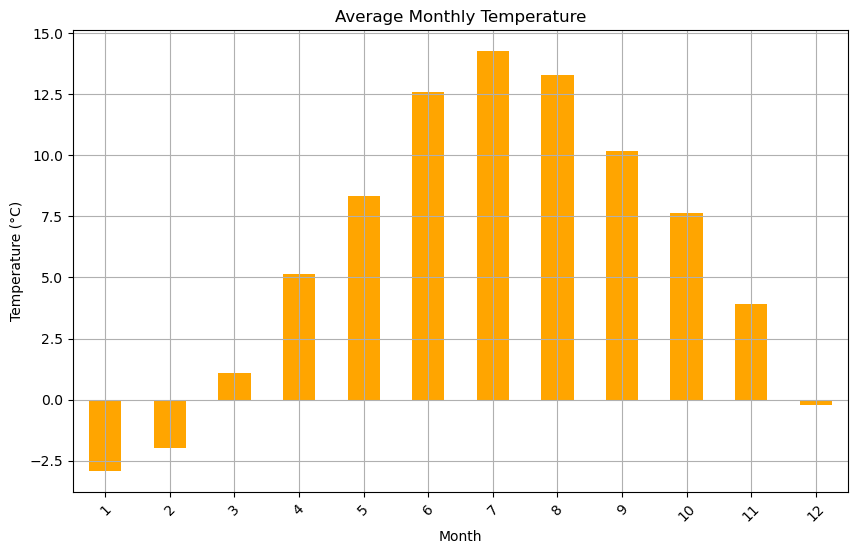

In [73]:
plot_seasonal_patterns(df)

## Function Documentation: `plot_extreme_weather_impact(merged_df)`

### Purpose
The `plot_extreme_weather_impact` function visualizes the impact of extreme weather conditions on energy demand by highlighting temperature anomalies and their effects on consumption.

### How It Works
1. **Identifies Extreme Weather Events**:
   - Filters `merged_df` for temperatures below -20°C or above 30°C to define extreme events.
2. **Creates a Scatter Plot**:
   - Uses `plt.figure(figsize=(12, 6))` to define the figure size.
   - Calls `plt.scatter(merged_df.index, merged_df['hourly_demand'], alpha=0.5, label='Normal Conditions')` to plot energy demand under normal weather.
   - Uses `plt.scatter(extreme_events.index, extreme_events['hourly_demand'], color='red', label='Extreme Weather', alpha=0.7)` to highlight demand under extreme weather conditions.
3. **Adds Labels and Titles**:
   - `plt.xlabel('Date')` and `plt.ylabel('Energy Demand')` to describe axes.
   - `plt.title('Impact of Extreme Weather on Energy Demand')` to provide context.
4. **Enhances Readability**:
   - Uses `plt.legend()` to differentiate between normal and extreme weather conditions.
   - Uses `plt.grid(True)` for better visualization.
5. **Displays the Plot**: Calls `plt.show()` to render the visualization.

### What to Look For
- **Demand Spikes or Drops**: Identify how extreme cold or heat influences energy consumption.
- **Seasonal Patterns**: Observe whether extreme weather follows specific seasonal trends.
- **Anomalies**: Detect outliers where energy demand deviates significantly due to extreme weather events.

### Insights
- Helps in **energy infrastructure planning**, ensuring reliable power supply during extreme weather.
- Supports **demand forecasting models**, predicting energy needs based on weather extremes.
- Useful for **climate resilience studies**, analyzing how extreme temperatures impact energy consumption trends.

---

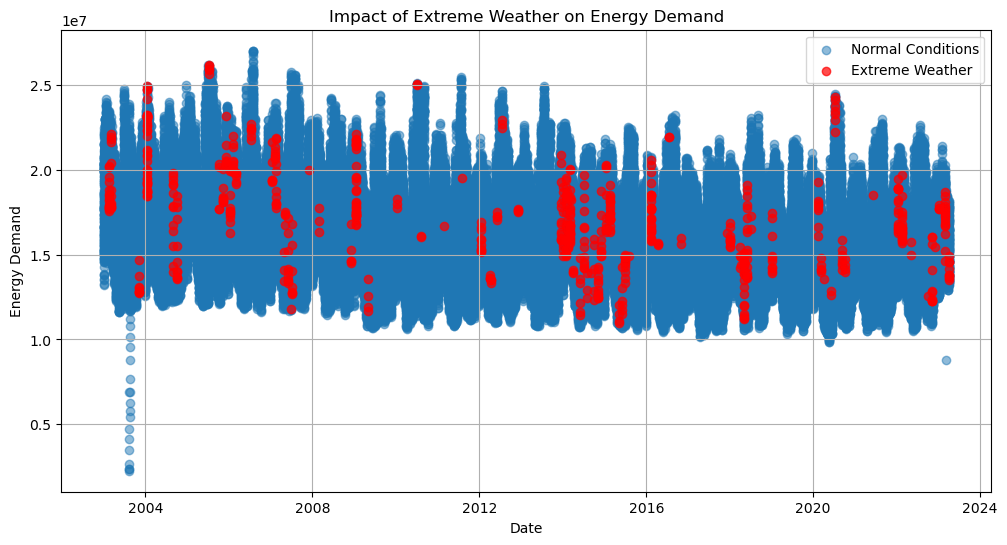

In [75]:
plot_extreme_weather_impact(df)

## Function Documentation: `plot_energy_vs_temperature(merged_df)`

### Purpose
The `plot_energy_vs_temperature` function visualizes the relationship between energy demand and temperature over time using a dual-axis plot.

### How It Works
1. **Creates a Figure and Axes**:
   - Uses `plt.subplots(figsize=(12, 6))` to create the main figure and primary y-axis (`ax1`).
2. **Plots Energy Demand**:
   - Uses `ax1.plot(merged_df.index, merged_df['hourly_demand'], label='Energy Demand', color='blue')` to display energy demand trends on the left y-axis.
   - Sets `ax1.set_ylabel('Energy Demand', color='blue')` to label the y-axis.
   - Uses `ax1.tick_params(axis='y', labelcolor='blue')` to color the left y-axis labels.
3. **Adds a Secondary Axis for Temperature**:
   - Uses `ax1.twinx()` to create a secondary y-axis (`ax2`).
   - Plots temperature data using `ax2.plot(merged_df.index, merged_df['Temp (°C)'], label='Temperature (°C)', color='red')`.
   - Sets `ax2.set_ylabel('Temperature (°C)', color='red')` to label the right y-axis.
   - Uses `ax2.tick_params(axis='y', labelcolor='red')` to color the right y-axis labels.
4. **Enhances Readability**:
   - Uses `plt.title('Energy Demand vs Temperature Over Time')` for context.
   - Calls `fig.tight_layout()` to optimize layout.
   - Uses `plt.grid(True)` to improve visualization.
5. **Displays the Plot**: Calls `plt.show()` to render the visualization.

### What to Look For
- **Inverse or Direct Relationships**: Determine if energy demand increases with colder or hotter temperatures.
- **Seasonal Trends**: Identify recurring patterns where temperature fluctuations affect energy usage.
- **Extreme Events**: Observe spikes in energy demand during extreme temperature periods.

### Insights
- Helps in **energy demand forecasting**, understanding temperature-driven consumption changes.
- Supports **climate impact studies**, analyzing how seasonal temperature variations affect power needs.
- Useful for **policy-making**, optimizing energy distribution based on temperature trends.

---

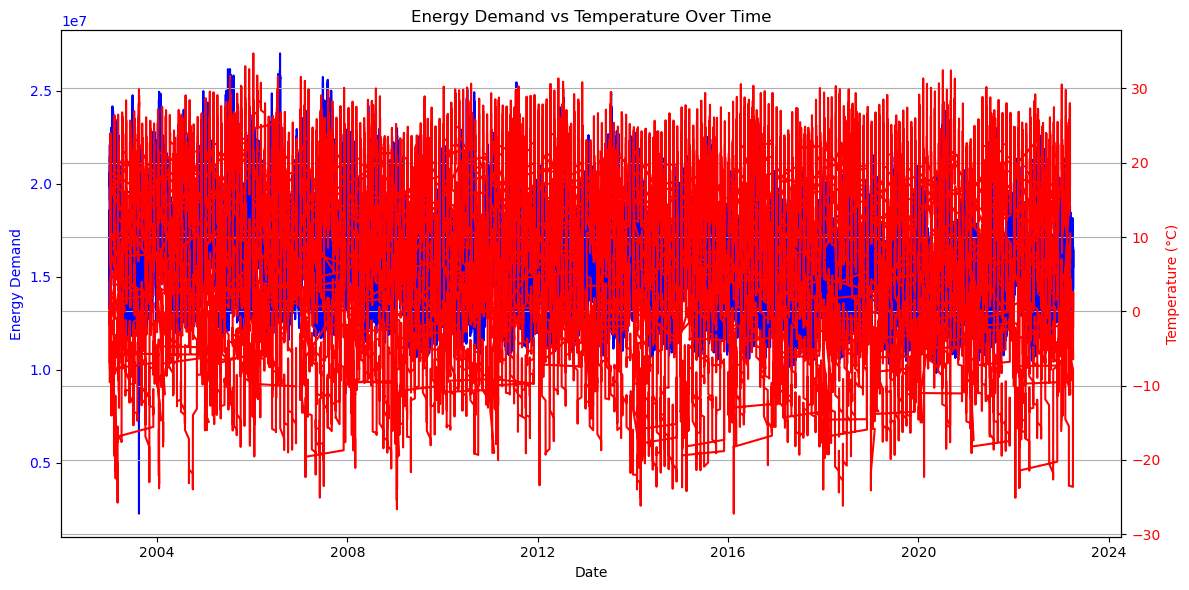

In [77]:
plot_energy_vs_temperature(df)

## Function Documentation: `plot_energy_demand_clusters(merged_df)`

### Purpose
The `plot_energy_demand_clusters` function applies K-Means clustering to group energy demand patterns based on climate variables such as temperature, humidity, and wind speed.

### How It Works
1. **Prepares Data for Clustering**:
   - Selects relevant climate and energy demand columns: `['Temp (°C)', 'Rel Hum (%)', 'Wind Spd (km/h)', 'hourly_demand']`.
   - Drops missing values using `.dropna()` to ensure valid clustering.
2. **Applies K-Means Clustering**:
   - Initializes `KMeans(n_clusters=3, random_state=42)` to create three clusters.
   - Fits the model on the selected data.
   - Assigns cluster labels to each data point.
3. **Plots Clusters**:
   - Uses `plt.figure(figsize=(12, 6))` to set the figure size.
   - Calls `sns.scatterplot(x='Temp (°C)', y='hourly_demand', hue='Cluster', data=data, palette='viridis')` to visualize clusters.
4. **Adds Labels and Titles**:
   - `plt.xlabel('Temperature (°C)')` and `plt.ylabel('Energy Demand')` to describe axes.
   - `plt.title('Energy Demand Clustering Based on Climate Variables')` to provide context.
5. **Displays the Plot**: Calls `plt.show()` to render the visualization.

### What to Look For
- **Distinct Clusters**: Identify whether groups of energy demand patterns emerge based on climate conditions.
- **Cluster Overlaps**: Observe if different weather conditions produce similar demand patterns.
- **Outliers**: Detect extreme values that may require further analysis.

### Insights
- Helps in **demand segmentation**, identifying different energy consumption behaviors based on climate.
- Supports **forecasting and optimization**, as different clusters may require different energy strategies.
- Useful for **climate impact studies**, understanding how temperature, humidity, and wind affect energy usage patterns.

---

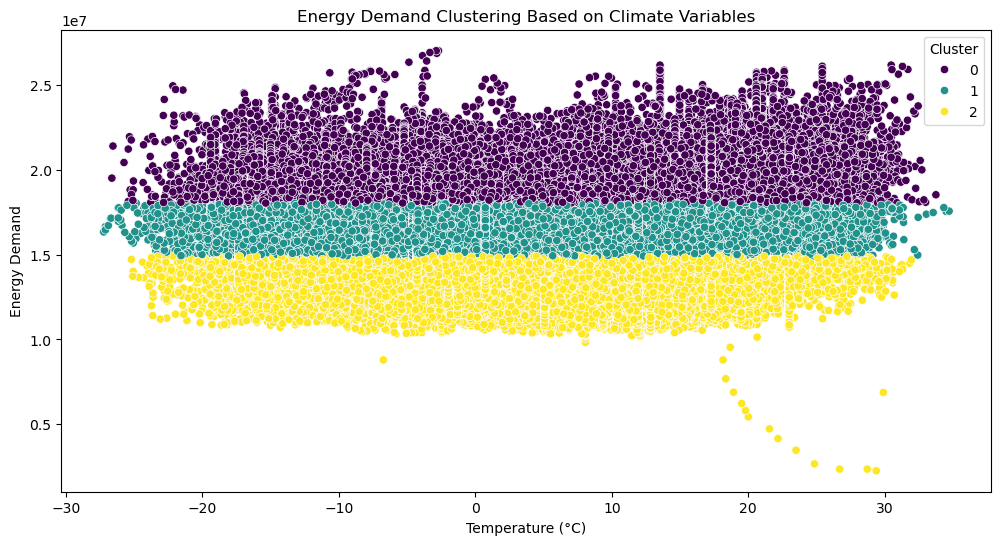

In [79]:
plot_energy_demand_clusters(df)

## Function Documentation: `compute_mutual_information(df, target_column)`

### Purpose
The `compute_mutual_information` function calculates the mutual information scores between features and a target variable, helping to identify the most relevant predictors for modeling.

### How It Works
1. **Prepares the Data**:
   - Selects only numeric columns using `df.select_dtypes(include=[np.number])`.
   - Drops missing values with `df.dropna()` to avoid errors in computation.
   - Checks if the target column exists; raises an error if not found.
2. **Computes Mutual Information**:
   - Splits the dataset into independent features (`X`) and the target variable (`y`).
   - Uses `mutual_info_regression(X, y, random_state=42)` to calculate mutual information scores for each feature.
   - Converts the scores into a pandas Series and sorts them in descending order.
3. **Plots the Results**:
   - Creates a bar plot using `mi_scores.plot(kind='bar', color='teal')`.
   - Adds labels and titles for better readability.
4. **Returns the Scores**:
   - Returns the sorted mutual information scores as a pandas Series.

### What to Look For
- **High Mutual Information Scores**: Features with high scores have a strong relationship with the target variable.
- **Low Scores**: Features with very low scores may not be relevant for prediction.
- **Unexpected Rankings**: Check if important features appear lower than expected, which may indicate issues with data processing.

### Insights
- Helps in **feature selection**, identifying the most useful predictors for modeling.
- Supports **dimensionality reduction**, allowing removal of irrelevant or redundant features.
- Enhances **model interpretability**, revealing which features contribute most to predicting the target variable.

---

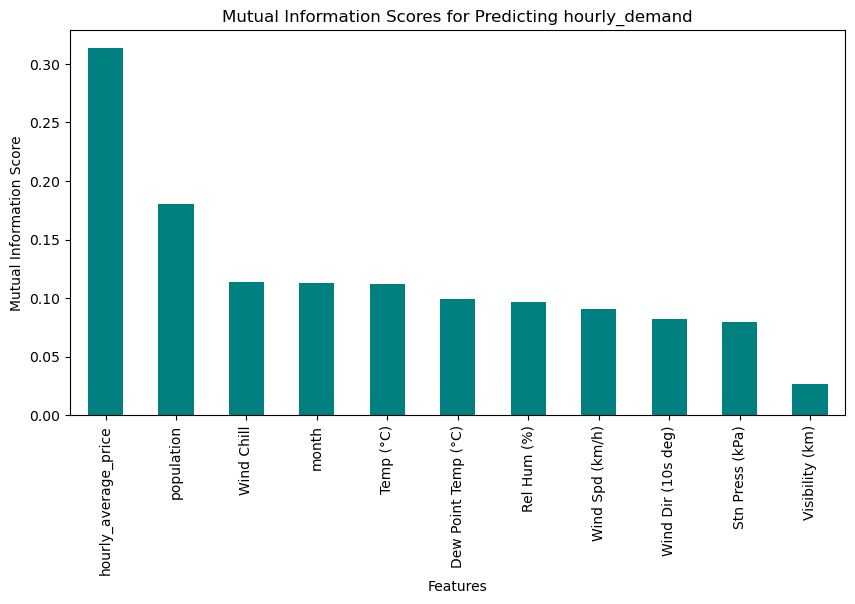

hourly_average_price    0.313219
population              0.180580
Wind Chill              0.113425
month                   0.113005
Temp (°C)               0.111572
Dew Point Temp (°C)     0.099597
Rel Hum (%)             0.096526
Wind Spd (km/h)         0.090712
Wind Dir (10s deg)      0.082179
Stn Press (kPa)         0.079778
Visibility (km)         0.026849
dtype: float64

In [83]:
compute_mutual_information(df,'hourly_demand')

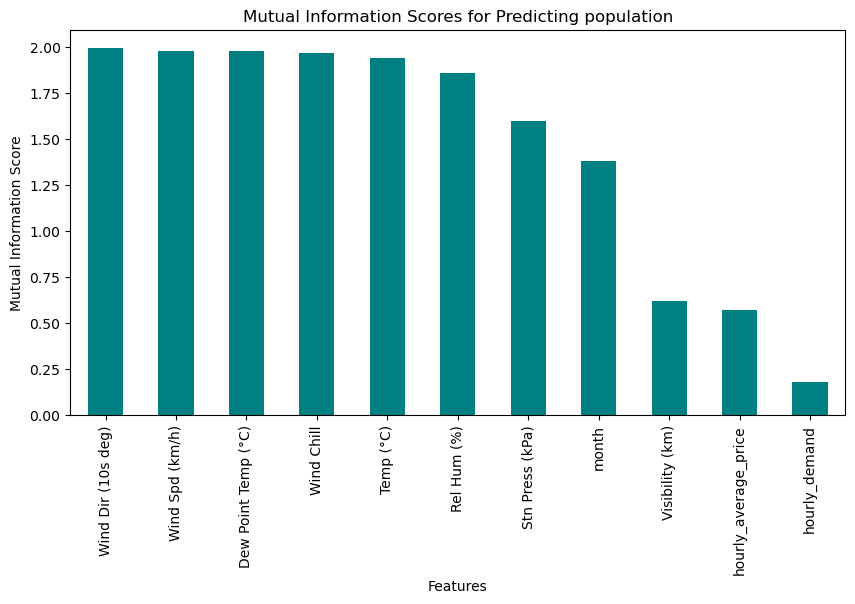

Wind Dir (10s deg)      1.993036
Wind Spd (km/h)         1.979461
Dew Point Temp (°C)     1.977727
Wind Chill              1.970587
Temp (°C)               1.943605
Rel Hum (%)             1.858223
Stn Press (kPa)         1.599469
month                   1.381957
Visibility (km)         0.618034
hourly_average_price    0.573463
hourly_demand           0.180544
dtype: float64

In [85]:
compute_mutual_information(df,'population')

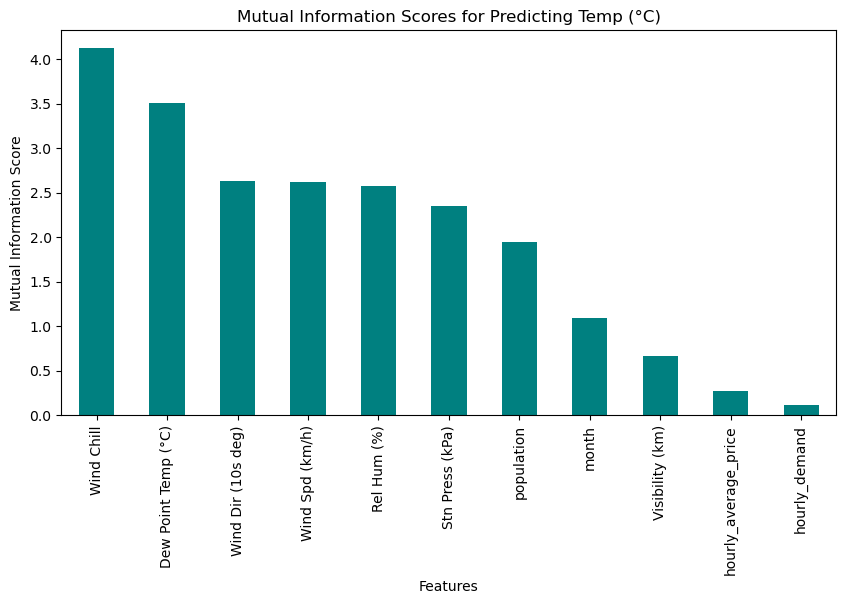

Wind Chill              4.120308
Dew Point Temp (°C)     3.502554
Wind Dir (10s deg)      2.632826
Wind Spd (km/h)         2.624443
Rel Hum (%)             2.579376
Stn Press (kPa)         2.349851
population              1.943866
month                   1.092364
Visibility (km)         0.662764
hourly_average_price    0.265526
hourly_demand           0.111746
dtype: float64

In [89]:
compute_mutual_information(df,'Temp (°C)')

## Function Documentation: `plot_arima_forecast(df, order=(5,1,0))`

### Purpose
The `plot_arima_forecast` function generates an energy demand forecast using an ARIMA model, helping to predict future consumption patterns based on historical data.

### How It Works
1. **Fits an ARIMA Model**:
   - Initializes an ARIMA model with the specified `order` (default: (5,1,0)).
   - Trains the model using `model.fit()` on the `hourly_demand` column.
   - Uses `model_fit.forecast(steps=30)` to generate a 30-step (hour) forecast.
2. **Creates a Forecast Plot**:
   - Uses `plt.figure(figsize=(12, 6))` to define the plot size.
   - Plots historical energy demand using `plt.plot(df.index, df['hourly_demand'], label='Historical Energy Demand')`.
   - Plots the ARIMA forecast on a future time range using `plt.plot(pd.date_range(df.index[-1], periods=30, freq='H'), forecast, label='Forecast', color='red')`.
3. **Adds Labels and Titles**:
   - `plt.xlabel('Date')` and `plt.ylabel('Energy Demand')` to describe axes.
   - `plt.title('Energy Demand Forecast using ARIMA')` to provide context.
4. **Enhances Readability**:
   - Uses `plt.legend()` to differentiate between historical data and forecast.
   - Uses `plt.show()` to display the visualization.

### What to Look For
- **Forecast Accuracy**: Compare forecasted values with actual trends in future periods.
- **Trend Continuation or Change**: Observe if the model predicts rising, falling, or stable demand.
- **Unexpected Spikes or Dips**: Check for anomalies that might indicate model overfitting or underfitting.

### Insights
- Helps in **energy planning**, predicting consumption patterns to optimize power generation.
- Supports **grid management**, allowing better load balancing based on future demand.
- Useful for **policy-making**, ensuring energy availability during peak periods.

---

C:\Users\waela\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\waela\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\waela\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\waela\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\waela\anaconda3\Lib\site-

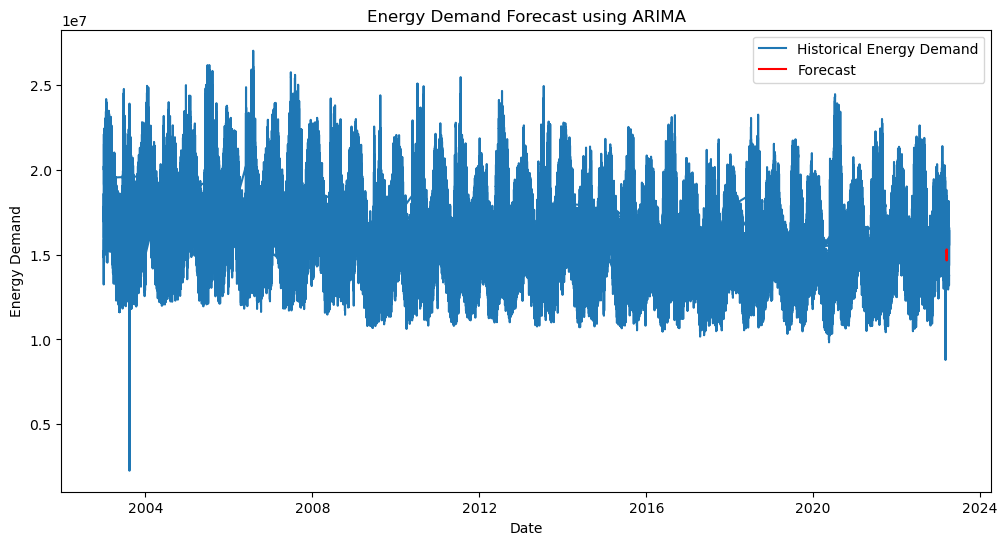

In [101]:
plot_arima_forecast(df)

## Function Documentation: `forecast_sarima(df, periods=30)`

### Purpose
The `forecast_sarima` function generates an energy demand forecast using a Seasonal ARIMA (SARIMA) model, incorporating seasonality to improve accuracy for periodic trends.

### How It Works
1. **Fits a SARIMA Model**:
   - Initializes a `SARIMAX` model with parameters:
     - `order=(5,1,0)`: Defines non-seasonal ARIMA terms.
     - `seasonal_order=(1,1,0,24)`: Specifies a seasonal component with a 24-hour cycle.
   - Trains the model using `model.fit(disp=False)` to suppress training output.
2. **Generates Forecast**:
   - Uses `model_fit.get_forecast(steps=periods)` to predict future demand.
   - Extracts forecasted mean values using `forecast.predicted_mean`.
   - Retrieves confidence intervals using `forecast.conf_int()`.
3. **Prepares Time Index for Forecast**:
   - Uses `pd.date_range(df.index[-1], periods=periods+1, freq='H')[1:]` to create a time index for predictions.
4. **Creates Forecast Plot**:
   - Uses `plt.figure(figsize=(12, 6))` to define the figure size.
   - Plots historical energy demand in blue.
   - Plots the SARIMA forecast in red.
   - Fills the confidence interval region using `plt.fill_between()`.
5. **Adds Labels and Titles**:
   - `plt.xlabel('Date')` and `plt.ylabel('Energy Demand')` to describe axes.
   - `plt.title('Energy Demand Forecast for Next 1-2 Years')` to provide context.
6. **Enhances Readability**:
   - Uses `plt.legend()` to differentiate historical data and forecast.
   - Uses `plt.show()` to render the visualization.
7. **Returns Forecast Data**:
   - Returns `forecast_mean`, `forecast_ci`, and `forecast_index` for further analysis.

### What to Look For
- **Seasonal Trends**: Observe how SARIMA captures recurring demand cycles.
- **Forecast Accuracy**: Compare confidence intervals with historical fluctuations.
- **Peak Demand Prediction**: Identify future high-demand periods for planning.

### Insights
- Helps in **long-term energy planning**, predicting demand for up to a year or more.
- Supports **seasonal energy allocation**, ensuring availability during peak periods.
- Useful for **policy and infrastructure development**, guiding grid expansion and optimization.

---

C:\Users\waela\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\waela\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\waela\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\waela\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\waela\anaconda3\Lib\site-

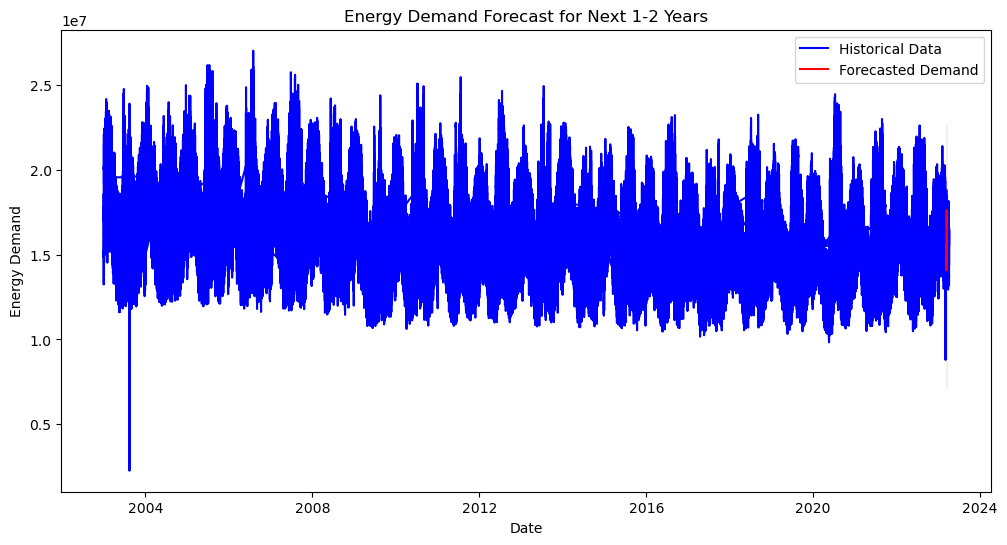

(177553    1.487726e+07
 177554    1.445784e+07
 177555    1.425550e+07
 177556    1.406484e+07
 177557    1.415685e+07
 177558    1.425856e+07
 177559    1.458904e+07
 177560    1.499668e+07
 177561    1.528061e+07
 177562    1.549966e+07
 177563    1.559171e+07
 177564    1.550402e+07
 177565    1.534071e+07
 177566    1.519336e+07
 177567    1.527061e+07
 177568    1.535905e+07
 177569    1.578603e+07
 177570    1.647242e+07
 177571    1.709729e+07
 177572    1.761235e+07
 177573    1.724988e+07
 177574    1.665842e+07
 177575    1.621651e+07
 177576    1.545469e+07
 177577    1.485044e+07
 177578    1.446423e+07
 177579    1.428557e+07
 177580    1.409782e+07
 177581    1.417995e+07
 177582    1.430191e+07
 Name: predicted_mean, dtype: float64,
         lower hourly_demand  upper hourly_demand
 177553         1.390194e+07         1.585258e+07
 177554         1.293579e+07         1.597989e+07
 177555         1.232012e+07         1.619089e+07
 177556         1.179405e+07         1.63

In [103]:
forecast_sarima(df)